# **Pool detection - Exploratory Data Analysis**

The main goal of this project is to determine which statistics
help to determine whether an image contains a pool or not, 
and then perform semantic segmentation on the pool.

Datasets obtained from:
- https://github.com/yacine-benbaccar/Pool-Detection
- https://www.kaggle.com/datasets/cici118/swimming-pool-detection-algarves-landscape

## **Libraries**

In [433]:
#%pip install scipy scikit-image scikit-learn numpy pandas matplotlib seaborn

In [434]:
import os
import shutil
import random
import collections
import warnings; warnings.filterwarnings('ignore')

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import exposure
from skimage.feature import graycomatrix, graycoprops
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## **Constants**

In [435]:
DATA_DIR = os.path.join('..', 'data', 'datasets')
YACINE_DATASET_DIR = os.path.join(DATA_DIR, 'yacine', 'original_splits')
YACINE_CUSTOM_SPLITS_DIR = os.path.join(DATA_DIR, 'yacine', 'custom_splits')
FEATURES_DIR = os.path.join('..', 'data', 'features')

YACINE_SOURCE = 'yacine'
ALGARVES_SOURCE = 'algarves'

POSITIVE_LABEL = 'pools'
NEGATIVE_LABEL = 'no_pools'

The next cell can be modify to obtain personalized results:

In [436]:
USE_CACHE = True 
PLOT_RESULTS = True
SEED = 0
random.seed(SEED)

### **Dataset Analysis**

In [437]:
def load_yacine_dataset(dataset_path: str, source=YACINE_SOURCE):
    df = collections.defaultdict(list)
    train_path = os.path.join(dataset_path, 'train')
    validation_path = os.path.join(dataset_path, 'validation')
    
    for split, split_path in [('train', train_path), 
                              ('validation', validation_path)]:
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)

            if not os.path.isdir(label_path):
                continue

            for image_filename in os.listdir(label_path):
                image_path = os.path.join(label_path, image_filename)
                df['split'].append(split)
                df['path'].append(image_path)
                df['source'].append(source)
                df['label'].append(label)

    return pd.DataFrame(df)

In [438]:
df_yacine = load_yacine_dataset(YACINE_DATASET_DIR, YACINE_SOURCE)
df_yacine.head()

split                                               path  source     label
0  train  ..\data\datasets\yacine\original_splits\train\...  yacine  no_pools
1  train  ..\data\datasets\yacine\original_splits\train\...  yacine  no_pools
2  train  ..\data\datasets\yacine\original_splits\train\...  yacine  no_pools
3  train  ..\data\datasets\yacine\original_splits\train\...  yacine  no_pools
4  train  ..\data\datasets\yacine\original_splits\train\...  yacine  no_pools

### **Split Size and Balancing**

In [439]:
df_yacine['split'].value_counts()

split
train         2723
validation     355
Name: count, dtype: int64

Note that the owner of the dataset's repository named the test set as validation set.

From now on, his validation set will be our test set, 
and we will use a subset of the training set for hyperparameter tuning.

In [440]:
df_yacine['label'].value_counts()

label
pools       1577
no_pools    1501
Name: count, dtype: int64

As the dataset is already balanced, the splitting won't be performed using stratification.

We will use 10% of the total dataset for the validation set.

In [441]:
df_yacine_train = df_yacine[df_yacine['split'] == 'train']

val_ratio = 0.1
val_n = int(len(df_yacine) * 0.1)

df_yacine_train, df_yacine_val = train_test_split(df_yacine_train, 
                                                  test_size=val_n,
                                                  random_state=SEED)

In [442]:
df_yacine_train['label'].value_counts()

label
pools       1236
no_pools    1180
Name: count, dtype: int64

Without stratifying, the train set is still balanced in terms of labels.

### **Save splits**

In [449]:
def copy_images(filepaths: list[str], labels: str, new_dir: str):
    for image_path, label in zip(filepaths, labels):
        basename = os.path.basename(image_path)
        new_filepath = os.path.join(new_dir, label, basename)
        shutil.copy2(image_path, new_filepath)

In [450]:
custom_train_images = df_yacine_train['path'].tolist()
custom_validation_images = df_yacine_val['path'].tolist()

custom_train_labels = df_yacine_train['label'].tolist()
custom_validation_labels = df_yacine_val['label'].tolist()

custom_splits_train = os.path.join(YACINE_CUSTOM_SPLITS_DIR, 'train')
custom_splits_validation = os.path.join(YACINE_CUSTOM_SPLITS_DIR, 'validation')

copy_images(custom_train_images,
            custom_train_labels,
            custom_splits_train)
copy_images(custom_validation_images,
            custom_validation_labels,
            custom_splits_validation)

## **Images Analysis**

In [360]:
def read_image(image_path: str):
    return cv2.imread(image_path)[..., ::-1]

### **Metadata**

Here we will load some image information, such as its size and format.

In [361]:
images = [read_image(image_path) for image_path in df_yacine_train['path'].tolist()]
image_dimensions = [img.shape for img in images]

df_yacine_train['image'] = images
df_yacine_train['width'], df_yacine_train['height'], df_yacine_train['channels'] = list(zip(*image_dimensions))
df_yacine_train['pixel_number'] = df_yacine_train['width'] * df_yacine_train['height']
df_yacine_train['width_height_rate'] = df_yacine_train['width'] / df_yacine_train['height']

df_yacine_train[['width', 'height', 'channels']].nunique()

width       1
height      1
channels    1
dtype: int64

Note that each image has the same size and channel format.

### **Visualization**

Note that the images have really bad resolution, which will make the task harder
for our classifier, although the training will be computationally faster.

**Mostrar primeros datos**

In [362]:
def plot_image_samples(images, labels, n_samples=4):
    _, ax = plt.subplots(2, n_samples//2, figsize=(20, 10))

    for i, (image, label) in enumerate(zip(images, labels)):
        row_idx = 0 if i < n_samples//2 else 1
        col_idx = i if i < n_samples//2 else i - n_samples//2
        ax[row_idx, col_idx].imshow(image)
        ax[row_idx, col_idx].set_title(label)
        ax[row_idx, col_idx].axis('off')
        
    plt.tight_layout()

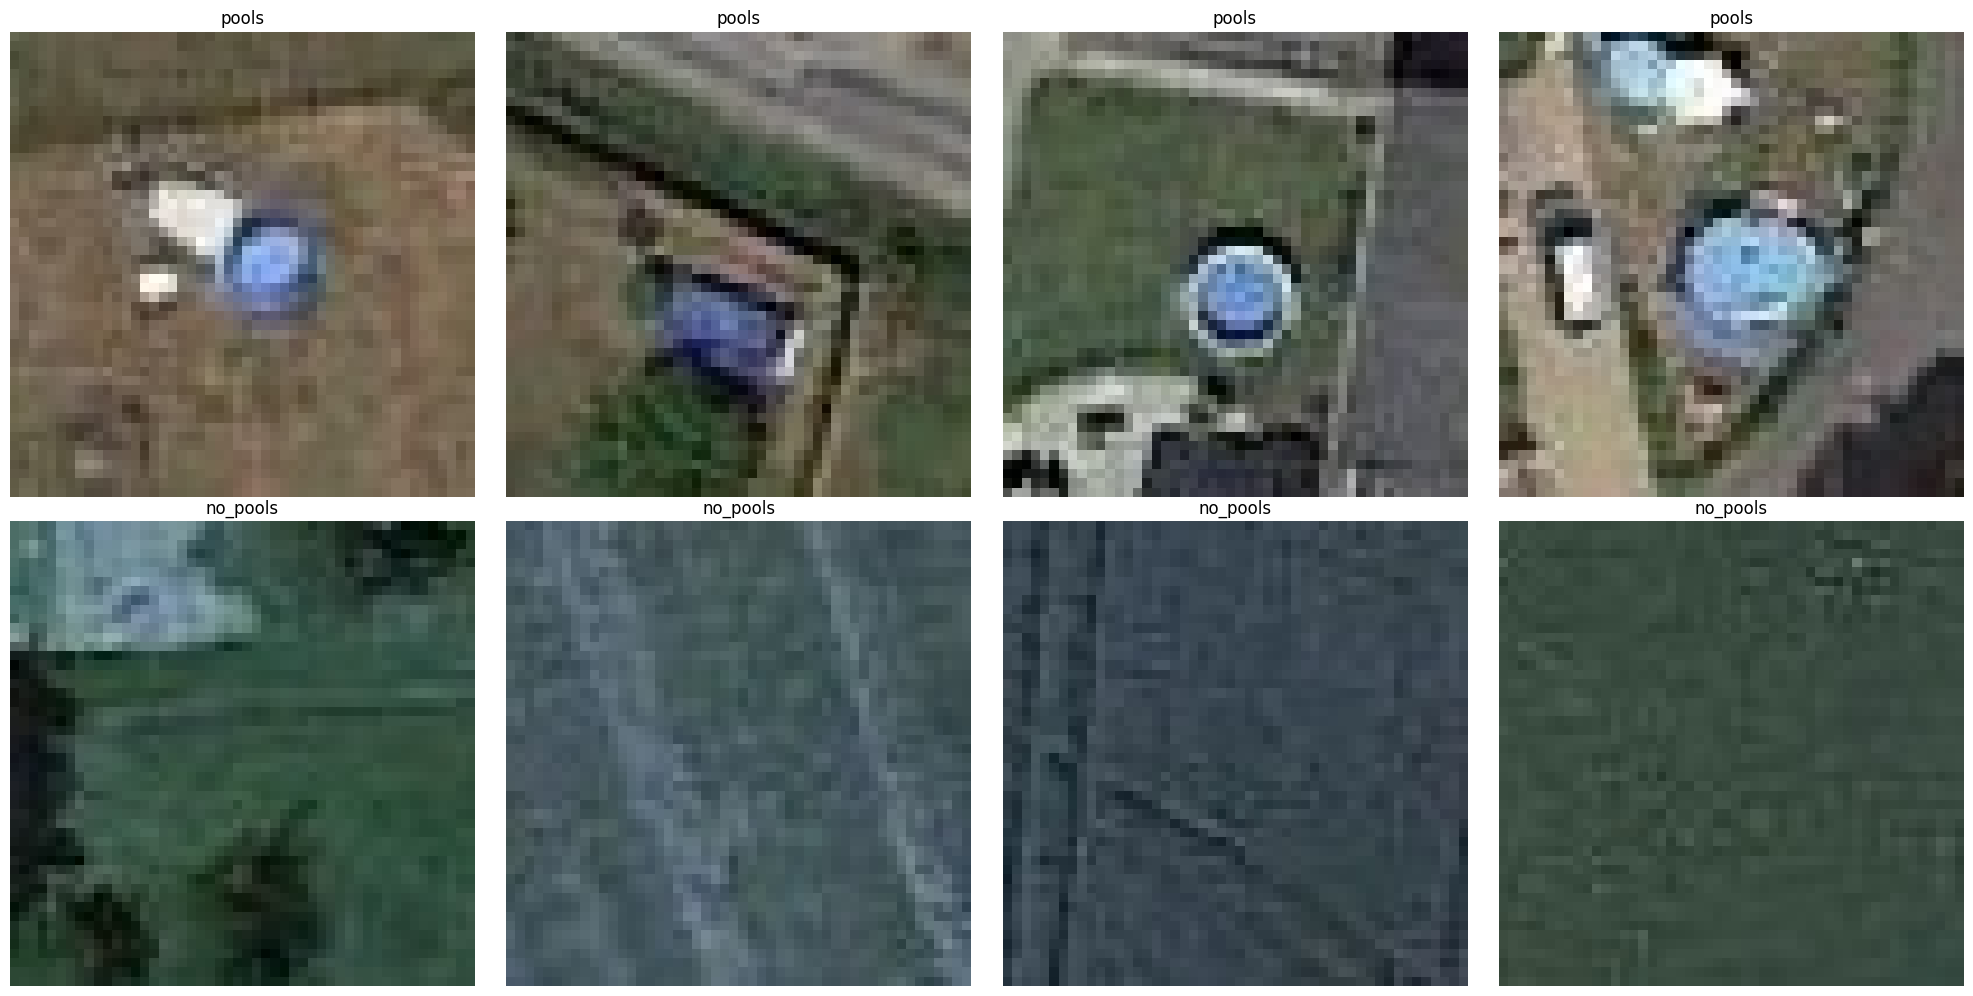

In [363]:
first_number = 8

positive_train_df = df_yacine_train[df_yacine_train['label'] == POSITIVE_LABEL]
negative_train_df = df_yacine_train[df_yacine_train['label'] == NEGATIVE_LABEL]
positive_images = positive_train_df['image'].tolist()
negative_images = negative_train_df['image'].tolist()

positive_images_showed = positive_images[:first_number//2]
negative_images_showed = negative_images[:first_number//2]

first_images = [*positive_images_showed, *negative_images_showed]
labels = [POSITIVE_LABEL]*len(positive_images_showed) + \
         [NEGATIVE_LABEL]*len(negative_images_showed)

if PLOT_RESULTS:
    plot_image_samples(first_images, labels, n_samples=first_number)

We will augment images using the next methods:
- Image rotation with a random angle
- Noise:
    - Random Noise
    - Gaussian Noise
- Gamma contrast adjustment

In [364]:
augmentation_functions = {'rotate': lambda image: rotate(image, random.randint(0, 360)),
                          'noise': lambda image: random_noise(image),
                          'gamma': lambda image: exposure.adjust_gamma(image, random.uniform(0.5, 1.5)),
                          'gaussian': lambda image: gaussian(image)}

In [365]:
def augment_images(
    images,
    labels,
    augment_rate=0.2,
    rotation_factor=0.05,
    noise_factor=0.025,
    gamma_factor=0.025,
    gaussian_factor=0.1,
):
    augmentation_rates = [rotation_factor, noise_factor, gamma_factor, gaussian_factor]
    rates = sum(augmentation_rates)
    if rates != augment_rate:
        print('Warning: Augment rate is not equal to sum of augmentation rates')
        gaussian_factor += augment_rate - rates

    augmented_images = []
    for image, label in zip(images, labels):
        if random.random() < augment_rate:
            function = random.choices(
                list(augmentation_functions.keys()), 
                weights=[rotation_factor, noise_factor, gamma_factor, gaussian_factor]
            )[0]
            augmented_image = augmentation_functions[function](image)
            min_image, max_image = np.min(augmented_image), np.max(augmented_image)
            augmented_image = ((augmented_image - min_image) / (max_image - min_image)) * 255
            augmented_image = augmented_image.astype(np.uint8)
            augmented_images.append((augmented_image, label, image))
    return augmented_images

In [366]:
augmented_train_images = augment_images(first_images, labels, 
                                        augment_rate=1,
                                        rotation_factor=0.25, 
                                        noise_factor=0.25, 
                                        gamma_factor=0.25, 
                                        gaussian_factor=0.25)

In [367]:
def compare_augmented_images(augmented_images):
    _, ax = plt.subplots(2, len(augmented_images), figsize=(12, 5))
    for idx, (image, label, original_image) in enumerate(augmented_images):
        ax[0, idx].imshow(image)
        ax[1, idx].set_title(f'{label}')
        ax[0, idx].axis('off')

        ax[1, idx].imshow(original_image)
        ax[0, idx].set_title(f'Augmented')
        ax[1, idx].axis('off')
    plt.tight_layout()

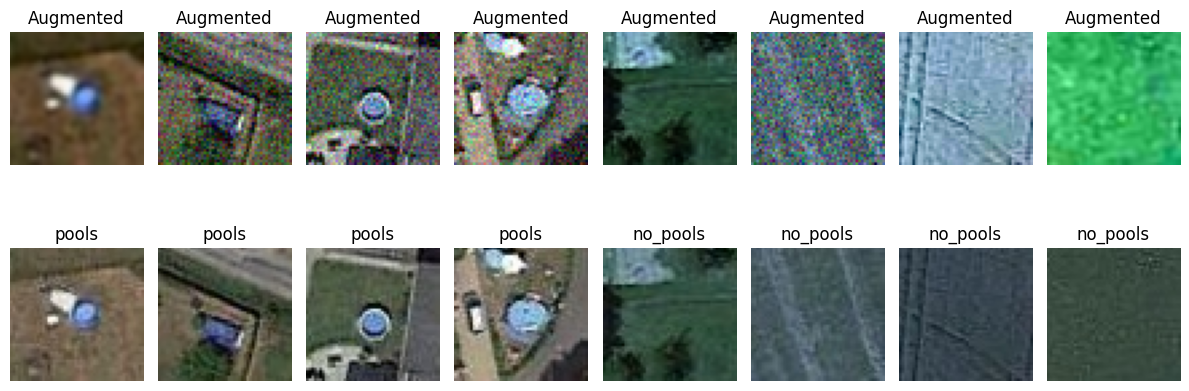

In [368]:
if PLOT_RESULTS:
    compare_augmented_images(augmented_train_images)

## **Feature Extraction**

Here, we will extract features from the training set and show their distribution,
as well as analysing it in a univariate and multivariate fashion.

The features we will used can be divided in the next sections:
- Color features: Which uses color properties
- Histogram features: Statistics over the distribution histogram of each RGB channel
- Grayscale coocurrence matrix features
- Others

In [369]:
train_images = df_yacine_train['image'].tolist()
train_labels = df_yacine_train['label'].tolist()
train_ids = df_yacine_train['path'].tolist()

#### **Color Features**

In [370]:
def has_blue(img):
    w, h, _ = img.shape
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_l = np.array([100, 150, 0])
    hsv_h = np.array([140, 255, 255])
    return cv2.inRange(hsv, hsv_l, hsv_h).any()

In [371]:
def create_color_features_df(images, labels, ids):
    features = []
    for image, label, id in zip(images, labels, ids):
        features.append((id, 'has_blue', int(has_blue(image)), label))
    return pd.DataFrame(features, columns=['image_id', 
                                           'feature_name', 
                                           'feature_value', 
                                           'label'])

In [372]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'color_features.csv')):
    color_features_df = pd.read_csv(os.path.join(FEATURES_DIR, 'color_features.csv'))
else:
    color_features_df = create_color_features_df(train_images, 
                                                 train_labels, 
                                                 train_ids)
    color_features_df.to_csv(os.path.join(FEATURES_DIR, 'color_features.csv'), index=False)


#### **RGB Channel Features**

##### **Measures of Central Tendency**

In [373]:
def calculate_mean(image_gray: np.ndarray):
    return image_gray.mean()

def calculate_median(image_gray: np.ndarray):
    return np.median(image_gray)

def calculate_mode(image_gray: np.ndarray):
    counts = [0] * 256
    for row in image_gray:
        for pixel in row:
            counts[pixel] += 1
    return np.argmax(counts)

##### **Dispersion Measures**

In [374]:
def calculate_std(image_gray: np.ndarray):
    return image_gray.std()

##### **Quantiles**

In [375]:
def calculate_min(image_gray: np.ndarray):
    return image_gray.min()

def calculate_max(image_gray: np.ndarray):
    return image_gray.max()

def calculate_range(image_gray: np.ndarray):
    return image_gray.max() - image_gray.min()

def calculate_quantile(image_gray: np.ndarray, q: float):
    bin_count = 256
    hist, bin_edges = np.histogram(image_gray, bins=bin_count)
    cum_values = np.cumsum(hist * np.diff(bin_edges))
    quantile = np.interp(q * 100, cum_values, bin_edges[:-1])
    return quantile

def calculate_iqr(image_gray: np.ndarray):
    return calculate_quantile(image_gray, 0.75) - calculate_quantile(image_gray, 0.25)

##### **Others**

In [376]:
def calculate_entropy(image_gray: np.ndarray):
    hist, _ = np.histogram(image_gray, bins=256)
    hist = hist[hist != 0]
    prob = hist / hist.sum()
    return -np.sum(prob * np.log2(prob)) / np.log2(len(prob))

def calculate_skewness(image_gray: np.ndarray):
    return stats.skew(image_gray, axis=None)

def calculate_kurtosis(image_gray: np.ndarray):
    return stats.kurtosis(image_gray, axis=None)

In [377]:
model_channel_feature_functions = {'mean': calculate_mean,
                                   'std': calculate_std,
                                   'median': calculate_median,
                                   'mode': calculate_mode,
                                   'min': calculate_min,
                                   'max': calculate_max,
                                   'range': calculate_range,
                                   'skewness': calculate_skewness,
                                   'kurtosis': calculate_kurtosis,
                                   'entropy': calculate_entropy,
                                   'quantile_0.25': lambda img: calculate_quantile(img, q=0.25),
                                   'quantile_0.75': lambda img: calculate_quantile(img, q=0.75),
                                   'iqr': calculate_iqr}

In [378]:
def create_channel_feature_df(images, labels, ids, model_feature_functions, include_grayscale=True):
    channels = ['red', 'green', 'blue'] + (['grayscale'] if include_grayscale else [])
    pixels_df = collections.defaultdict(list)

    for id, image, label in zip(ids, images, labels):
        for feature_name, feature_function in model_feature_functions.items():
            for chnl in range(3):
                pixels_df['image_id'].append(id)
                pixels_df['feature_value'].append(feature_function(image[:, :, chnl]))
                pixels_df['feature_name'].append(feature_name)
                pixels_df['channel'].append(channels[chnl])
                pixels_df['label'].append(label)

            if include_grayscale:
                averaged_image = np.clip(image.mean(axis=2).astype(int), 0, 255)
                pixels_df['image_id'].append(id)
                pixels_df['feature_value'].append(feature_function(averaged_image))
                pixels_df['feature_name'].append(feature_name)
                pixels_df['channel'].append('grayscale')
                pixels_df['label'].append(label)

    df = pd.DataFrame(pixels_df)
    df['feature_value'] = df['feature_value'].astype(float)
    return df

In [379]:
def scale_feature_df(channel_feature_df: pd.DataFrame):
    channel_feature_df = channel_feature_df.copy()
    for feature_name in channel_feature_df['feature_name'].unique():
        feature_values = channel_feature_df[channel_feature_df['feature_name'] == feature_name]['feature_value']
        current_features_max = feature_values.max()
        current_features_min = feature_values.min()
        feature_values = (feature_values - current_features_min) / \
                         (current_features_max - current_features_min)
        channel_feature_df.loc[channel_feature_df['feature_name'] == feature_name, 'feature_value'] = feature_values
    return channel_feature_df

In [380]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'channel_feature_df.csv')):
    channel_feature_df = pd.read_csv(os.path.join(FEATURES_DIR, 'channel_feature_df.csv'))
else:
    channel_feature_df = create_channel_feature_df(train_images, 
                                                   train_labels, 
                                                   train_ids, 
                                                   model_channel_feature_functions)
    channel_feature_df.to_csv(os.path.join(FEATURES_DIR, 'channel_feature_df.csv'), index=False)

#### **Visual Analysis**

##### **Blue level according to the HSV blue region**

<Axes: xlabel='feature_value', ylabel='feature_name'>

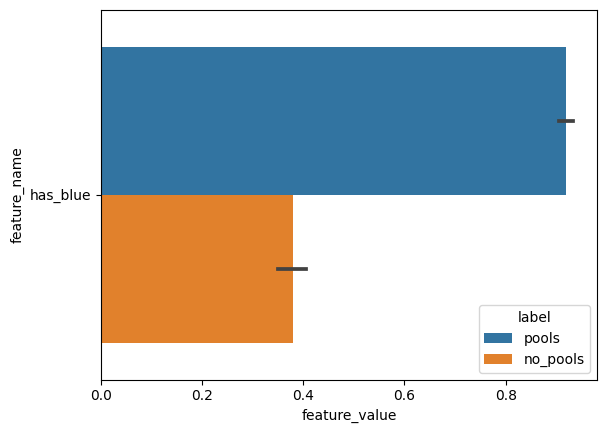

In [381]:
sns.barplot(x='feature_value', hue='label', data=color_features_df, y='feature_name')

##### **Separating channels**

**Feature Distribution for each channel**

In [382]:
def plot_histogram_features_violinplot(feature_df: pd.DataFrame):
    _, ax = plt.subplots(nrows=len(feature_df['channel'].unique()), figsize=(20, 20))
    
    for i, channel in enumerate(feature_df['channel'].unique()):
        current_feature_df = feature_df[feature_df['channel'] == channel]
        scaled_feature_df = scale_feature_df(current_feature_df)

        sns.violinplot(data=scaled_feature_df, 
                       x='feature_name', 
                       y='feature_value', 
                       hue='label', 
                       ax=ax[i])
        
        ax[i].legend(fontsize=10)
        ax[i].set_title(channel)
        plt.tight_layout()

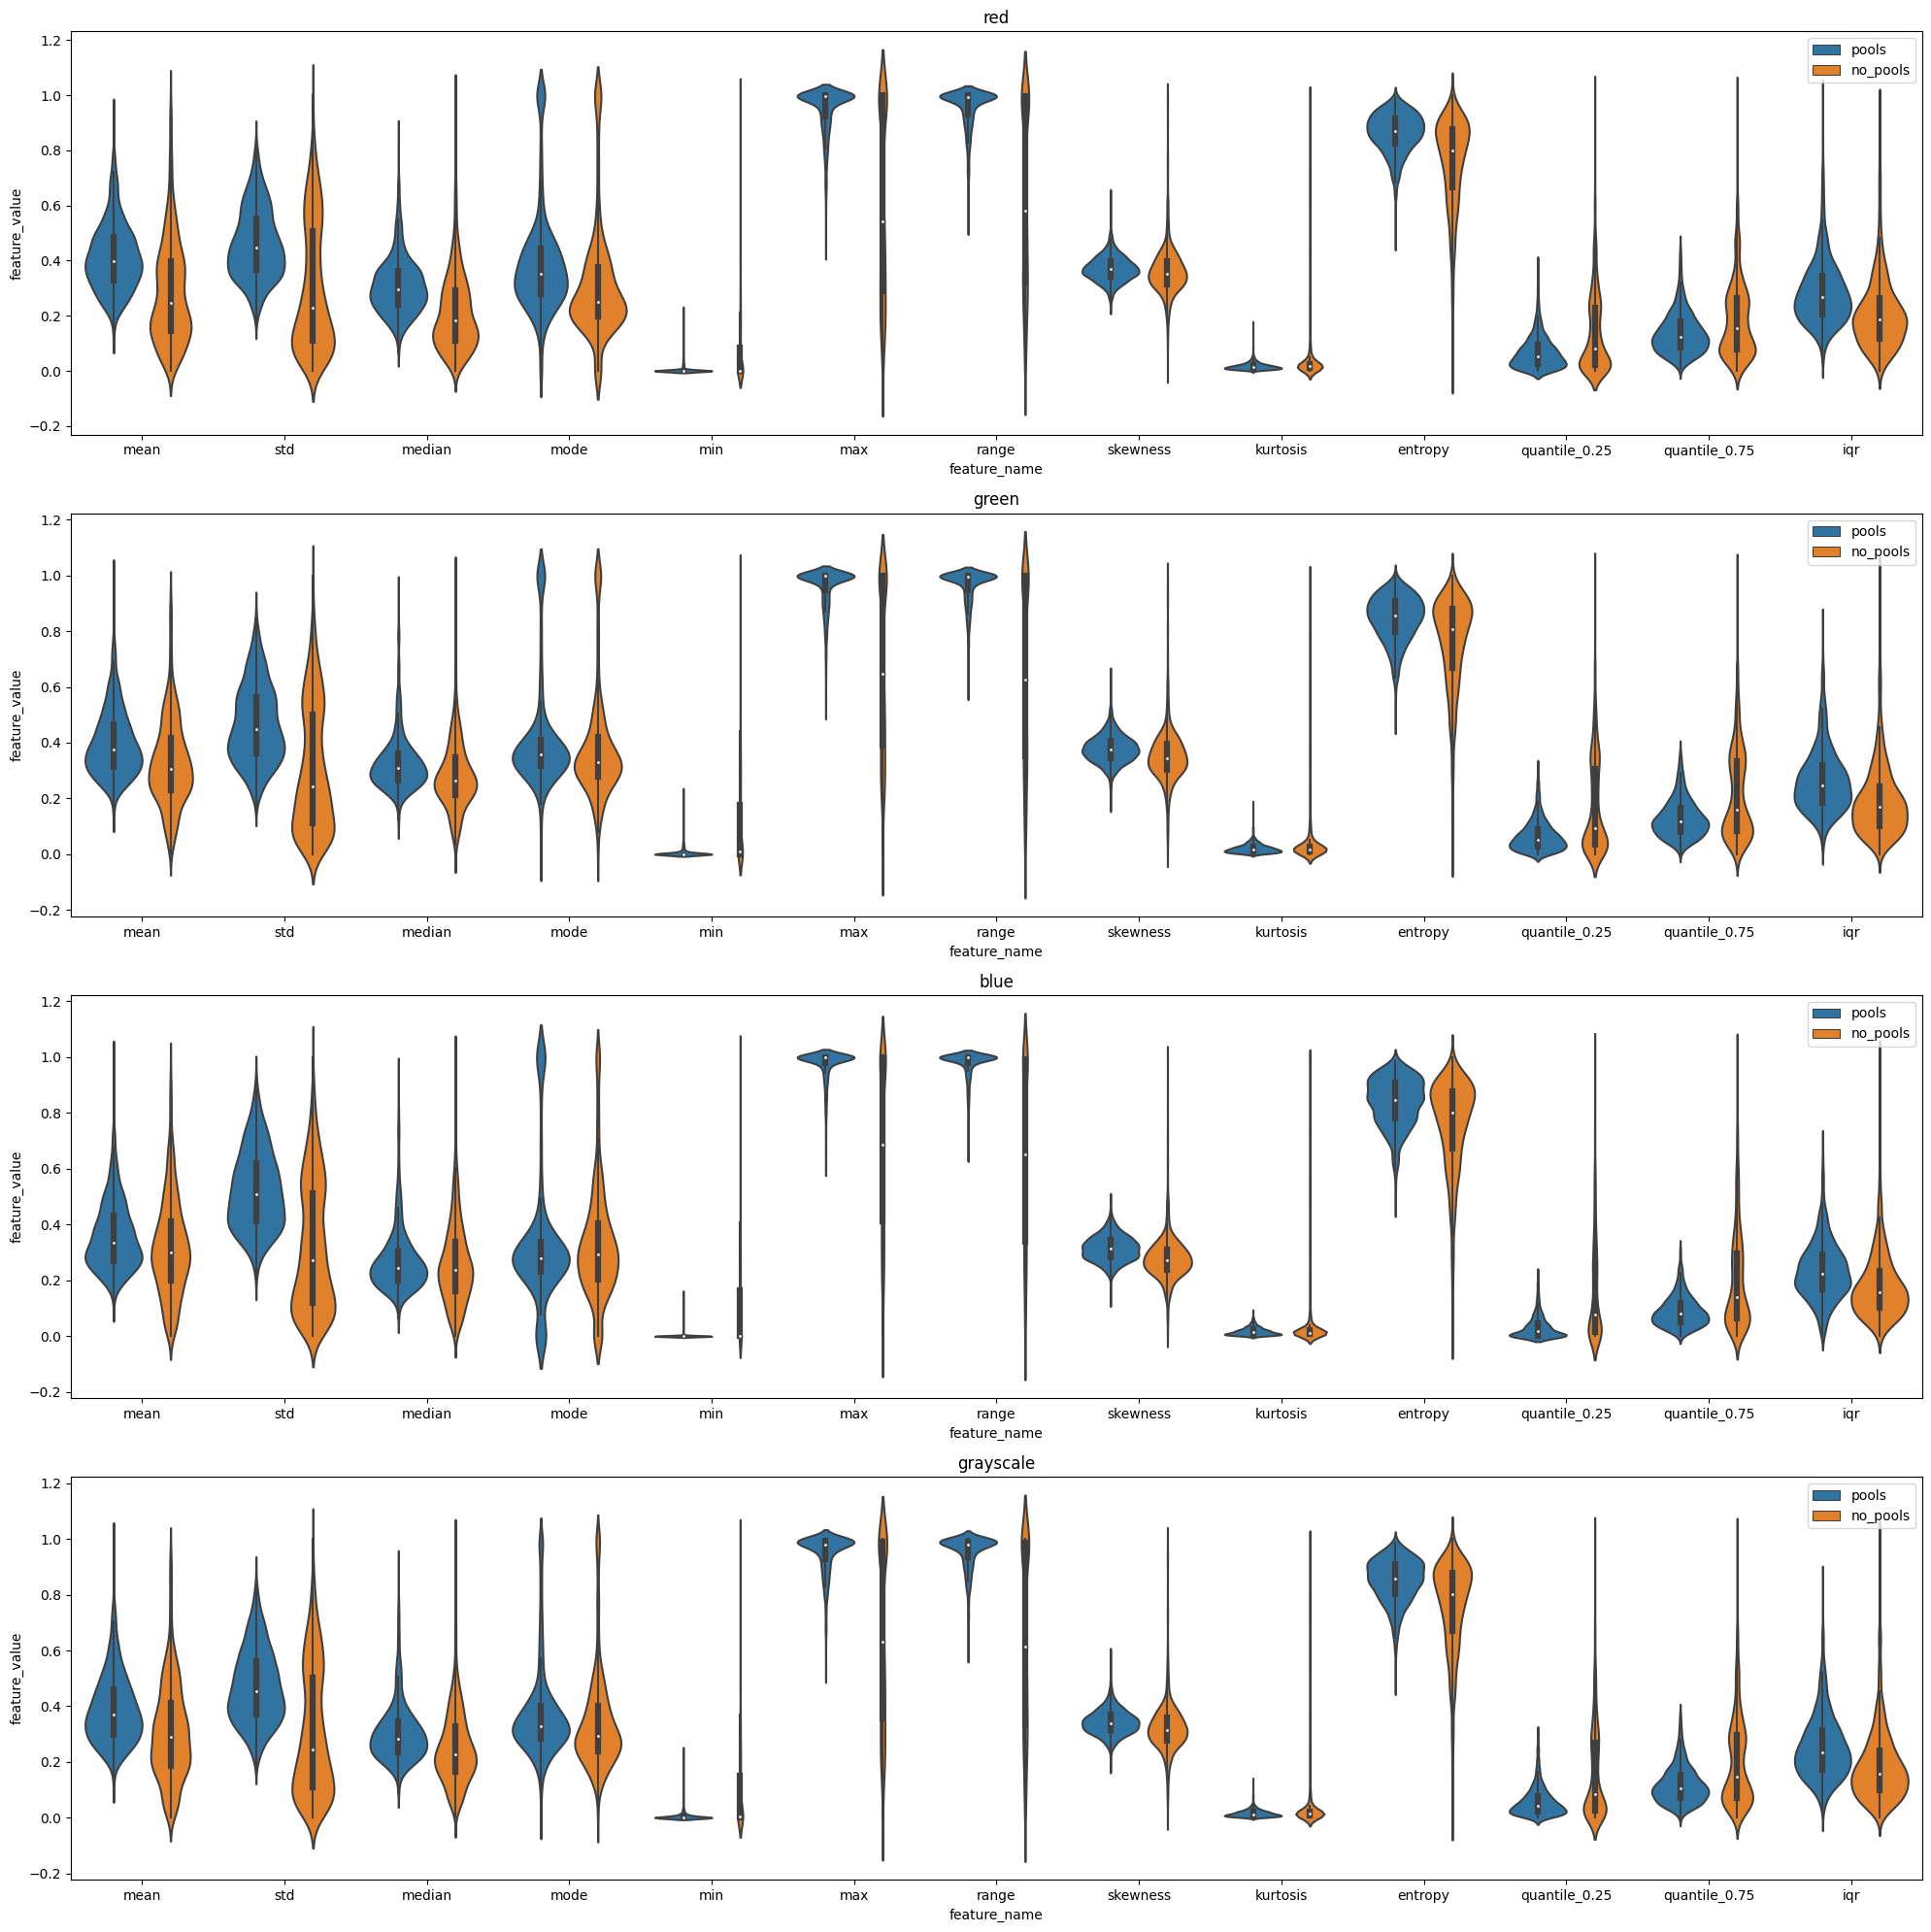

In [383]:
if PLOT_RESULTS:
    plot_histogram_features_violinplot(channel_feature_df)

**Univariate feature distribution**

In [384]:
def plot_channel_feature_df(pixels_df, color='red', 
                            secondary_color='blue', 
                            width=None, height=None):
    facet_grid = sns.displot(pixels_df, 
                             x='feature_value', 
                             hue='label', 
                             row='feature_name', col='channel', 
                             fill=True, palette=[secondary_color, color],
                             kind='kde')
    
    facet_grid.fig.set_figwidth(width) if width else None
    facet_grid.fig.set_figheight(height) if height else None

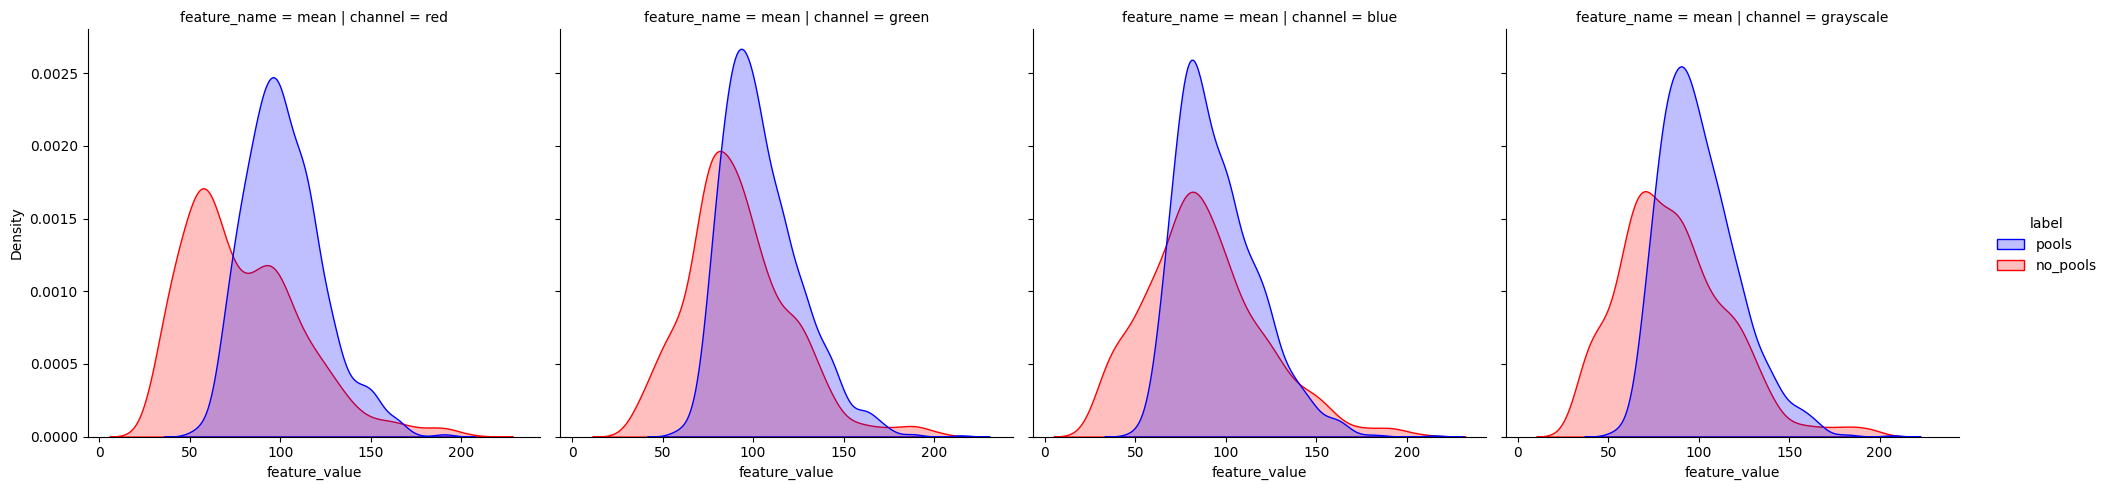

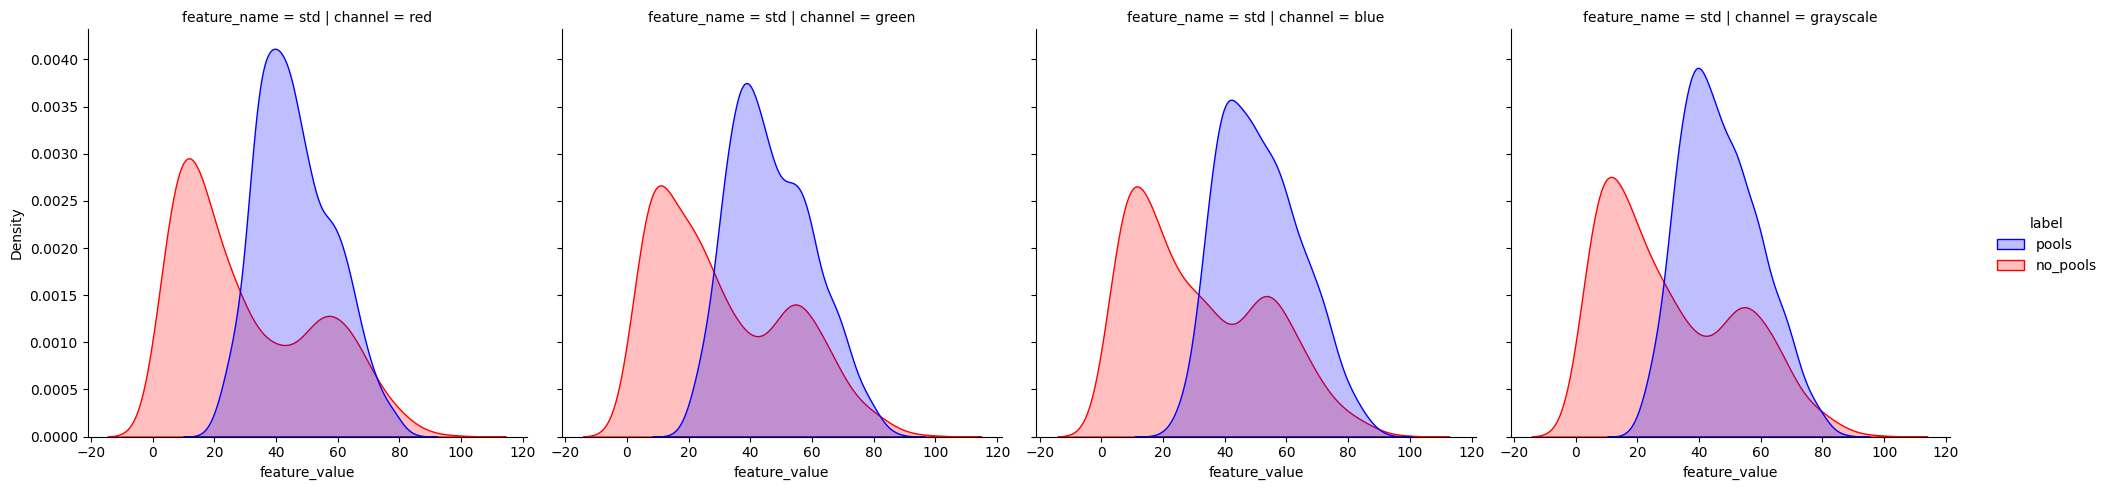

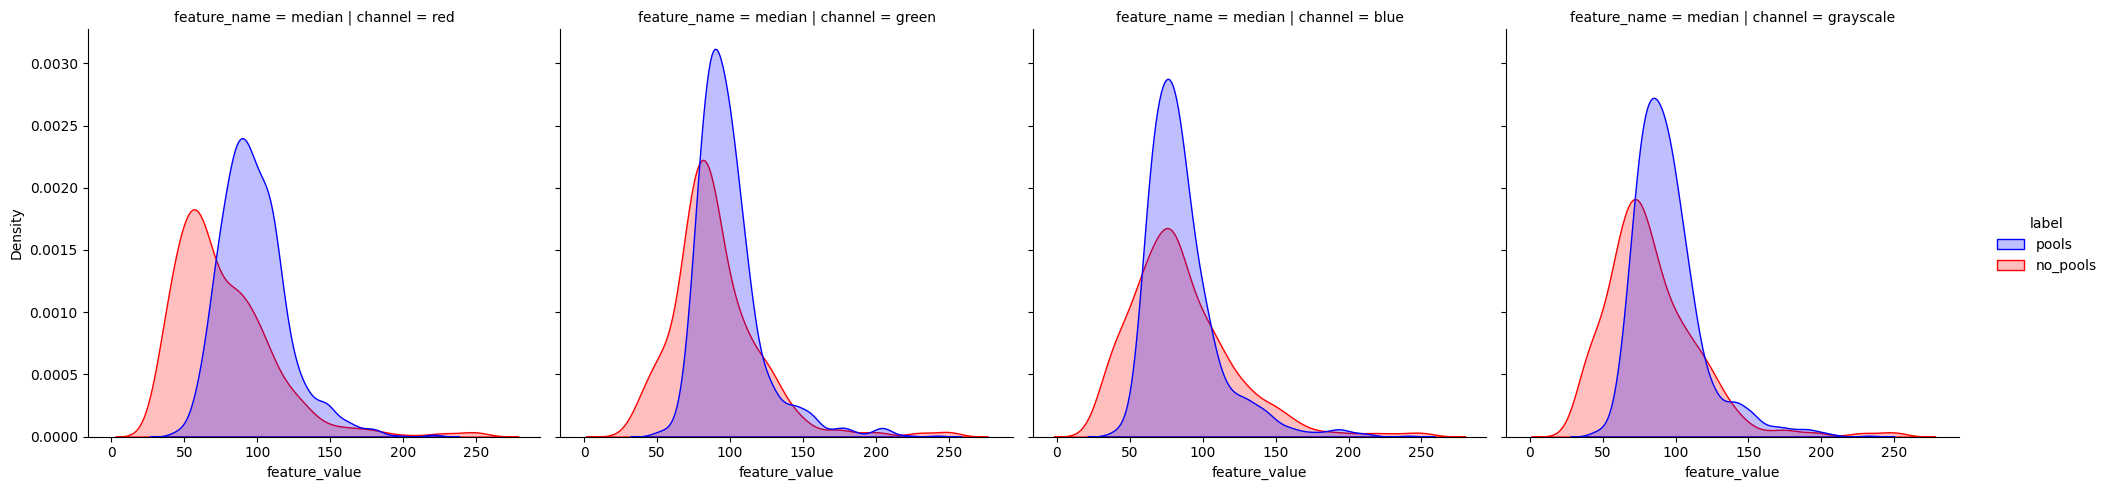

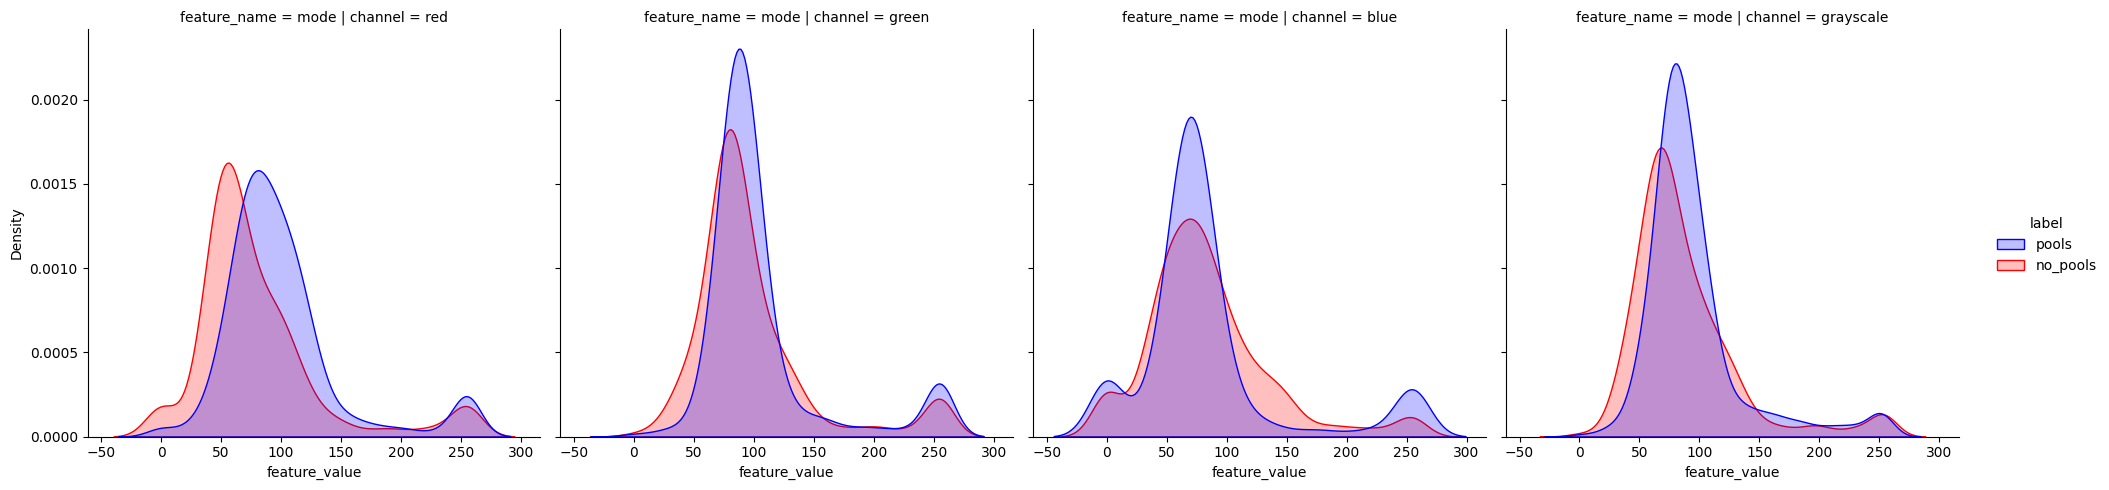

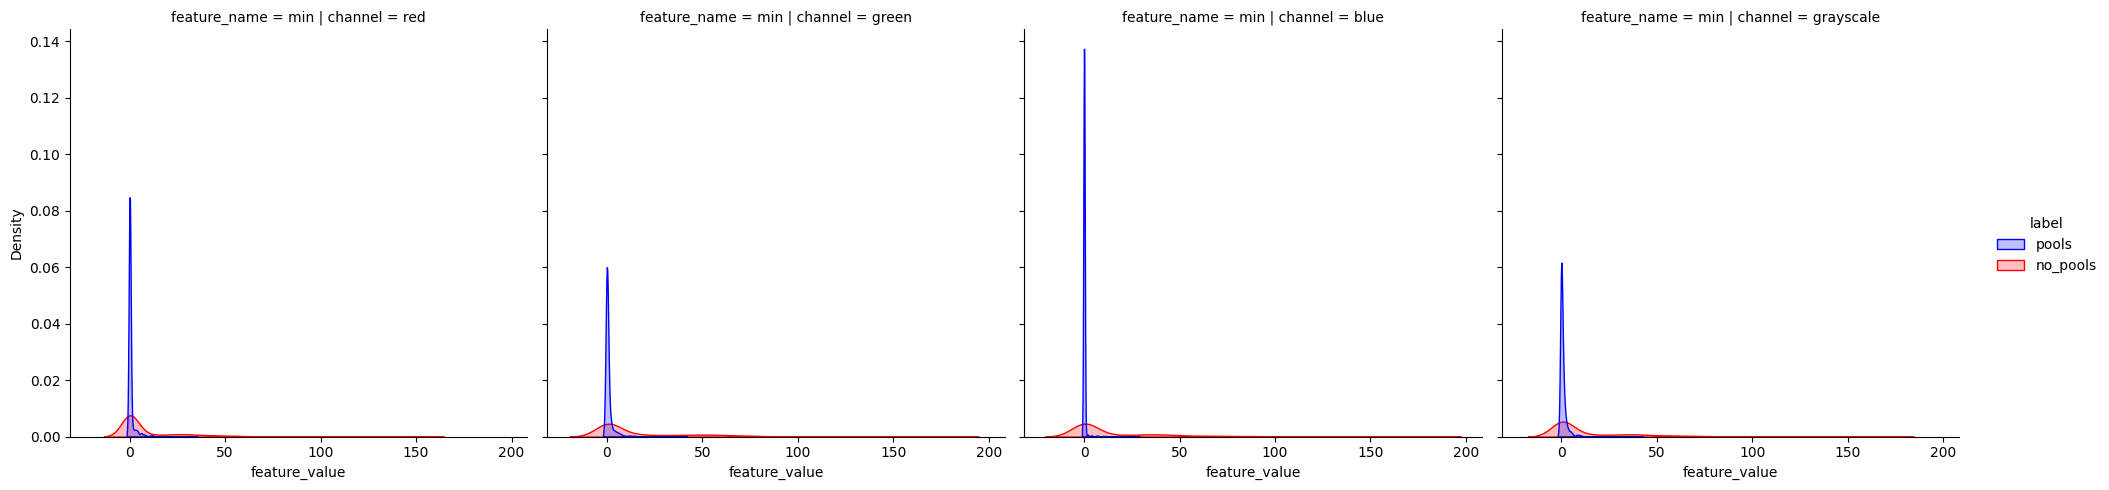

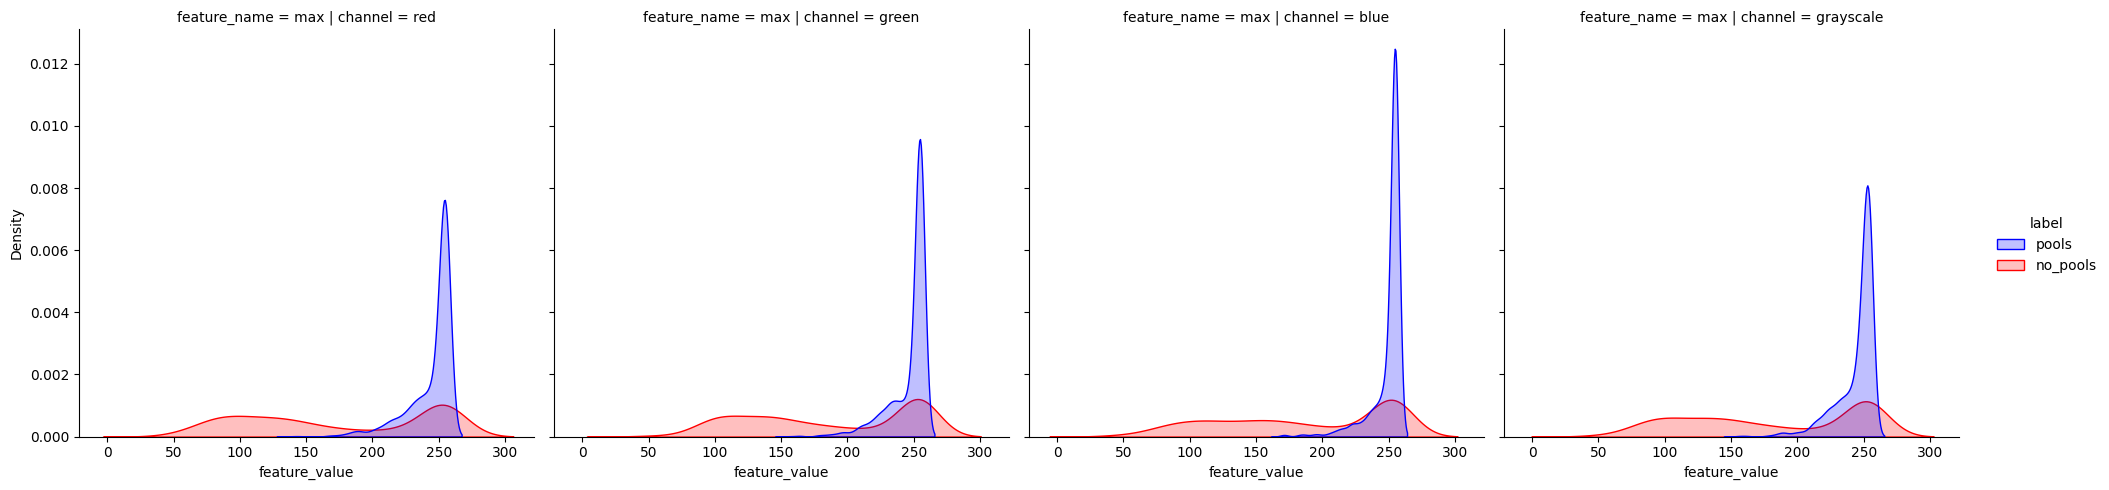

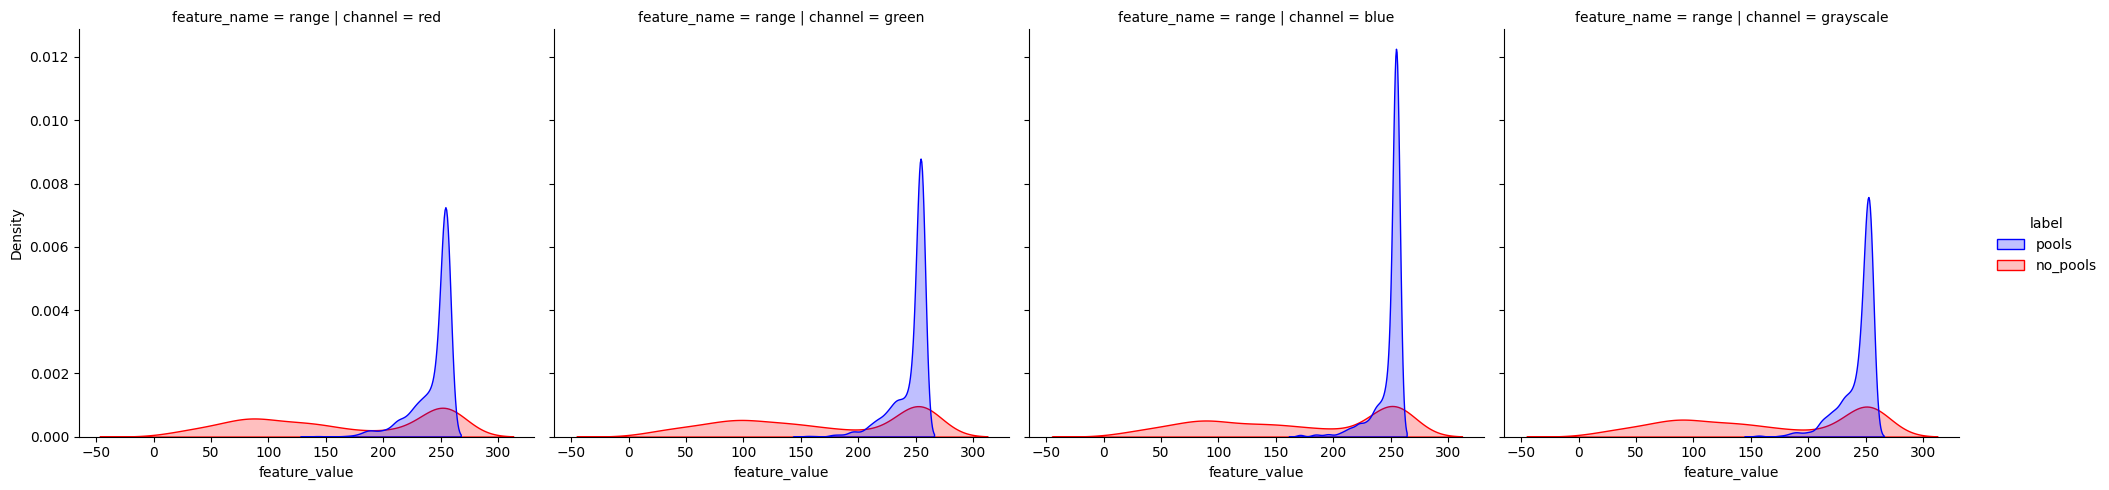

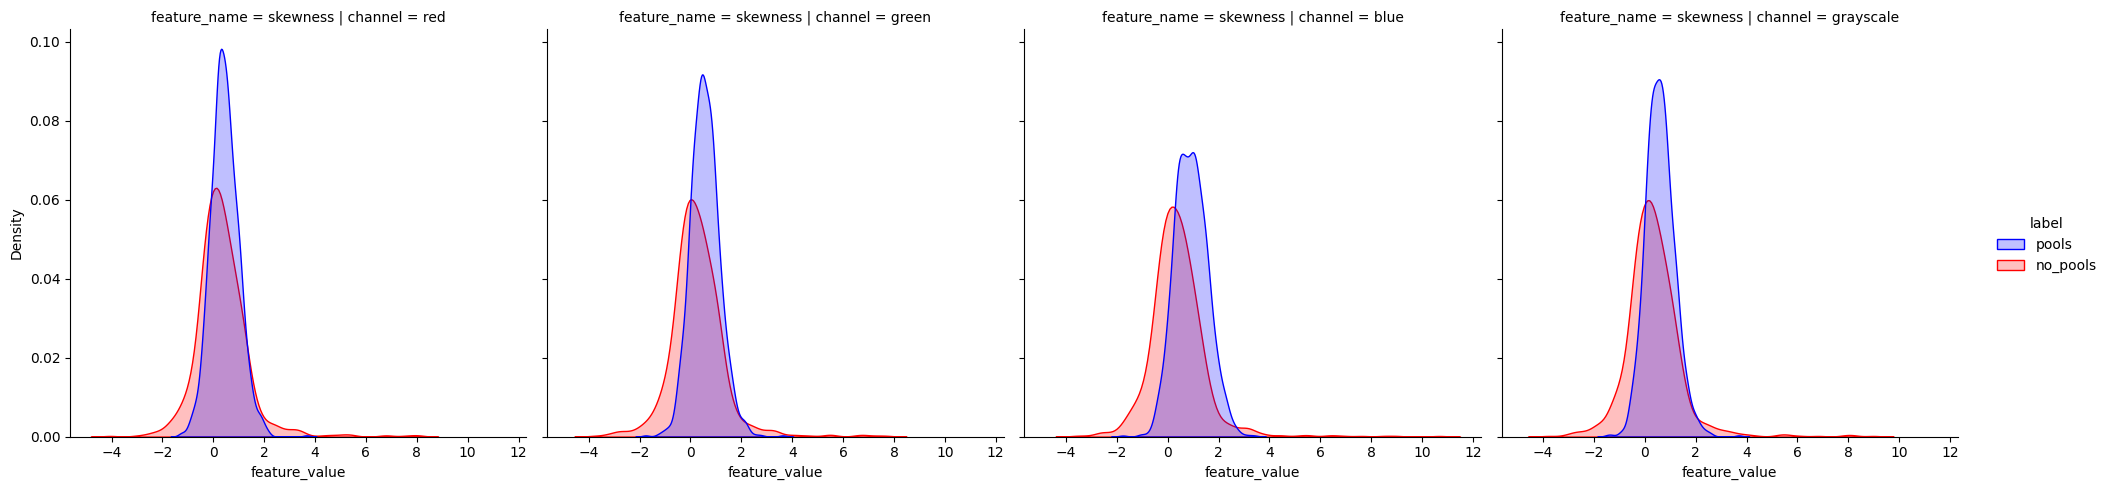

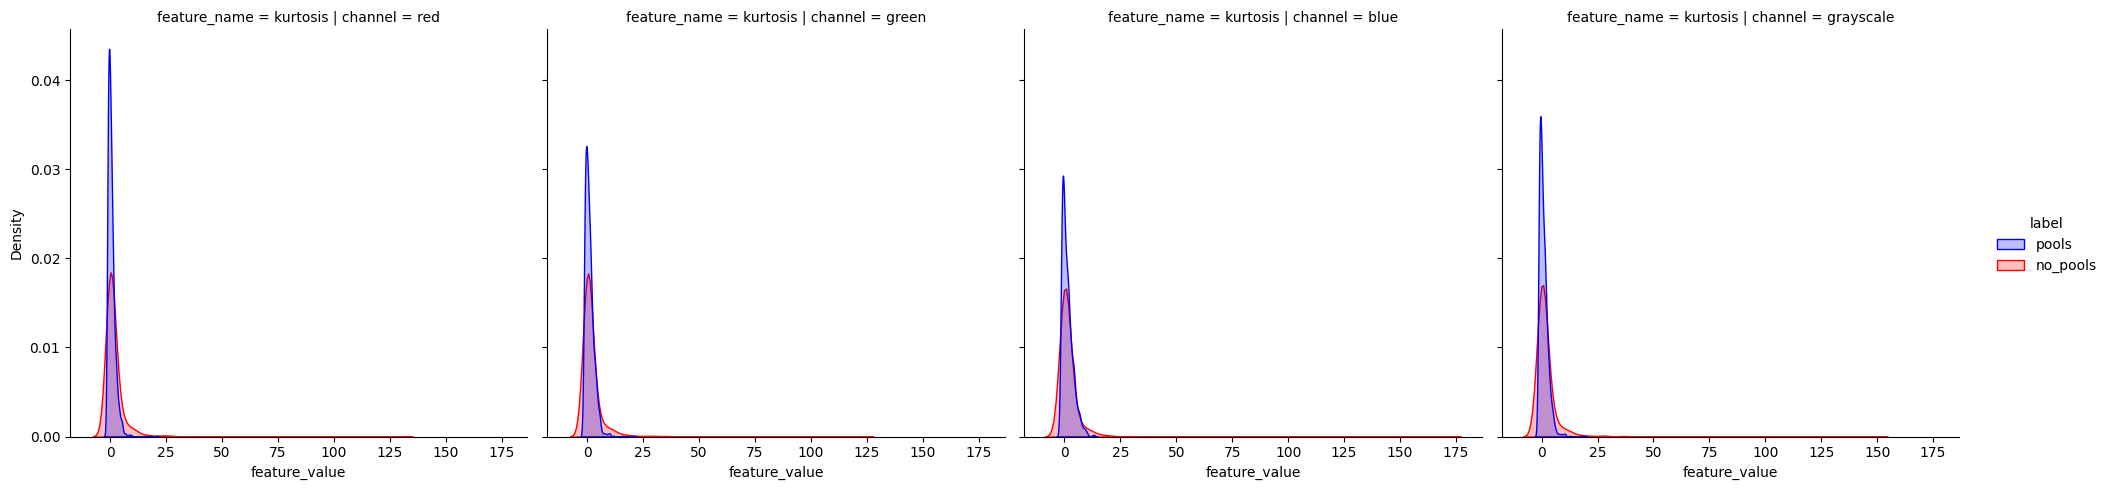

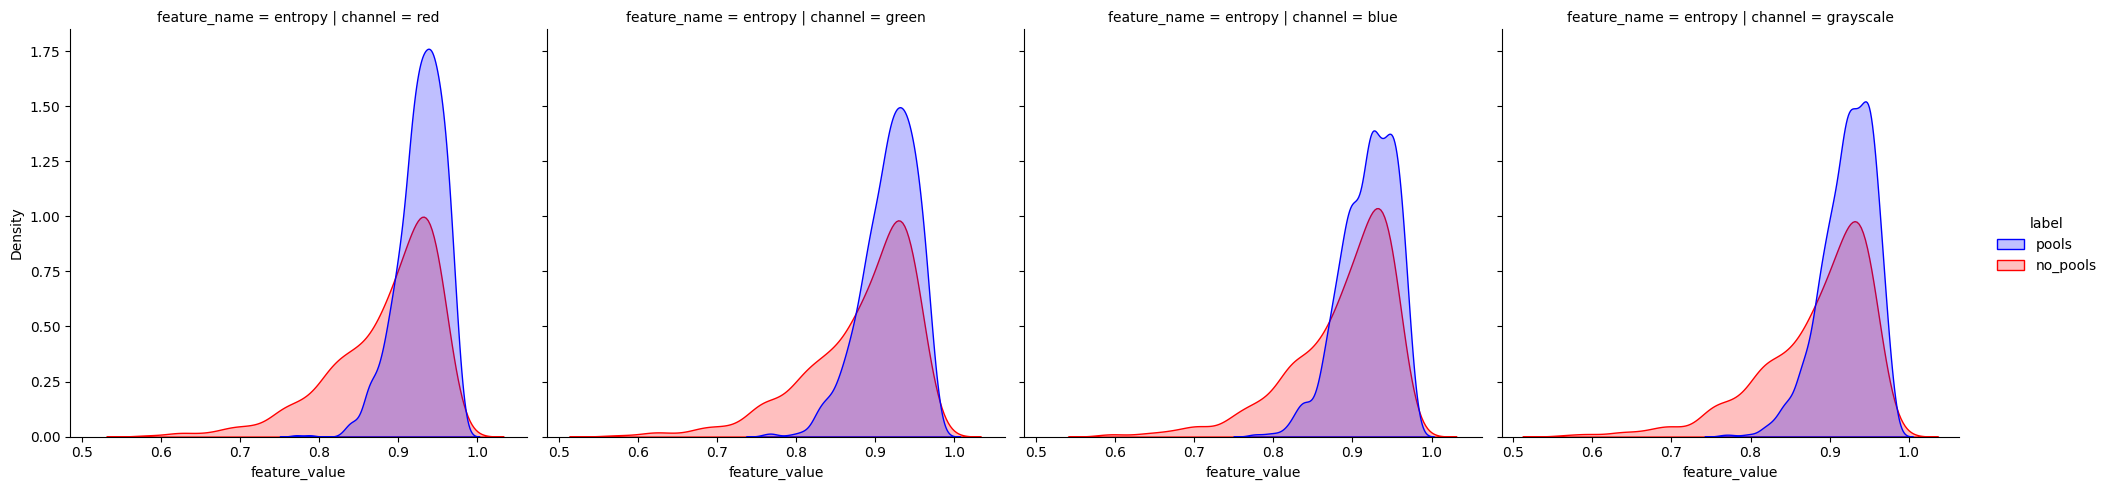

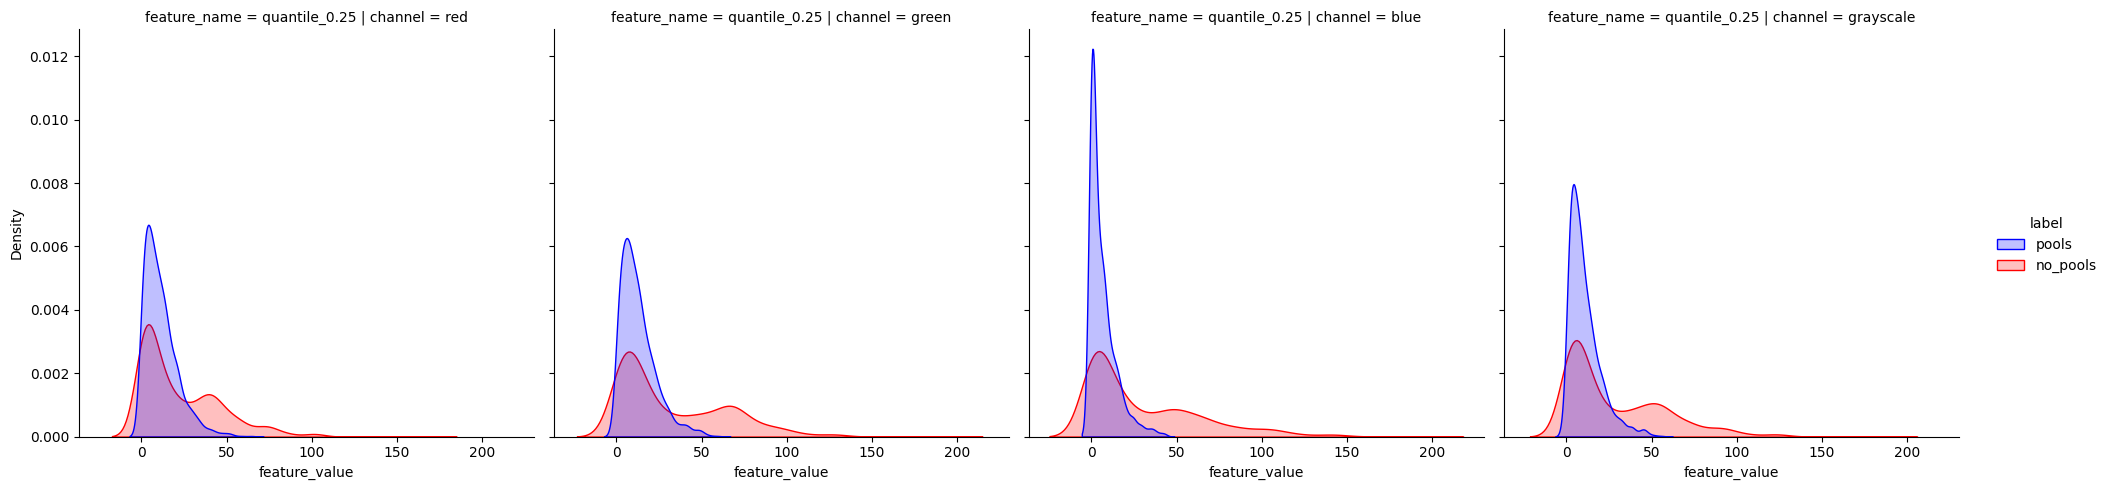

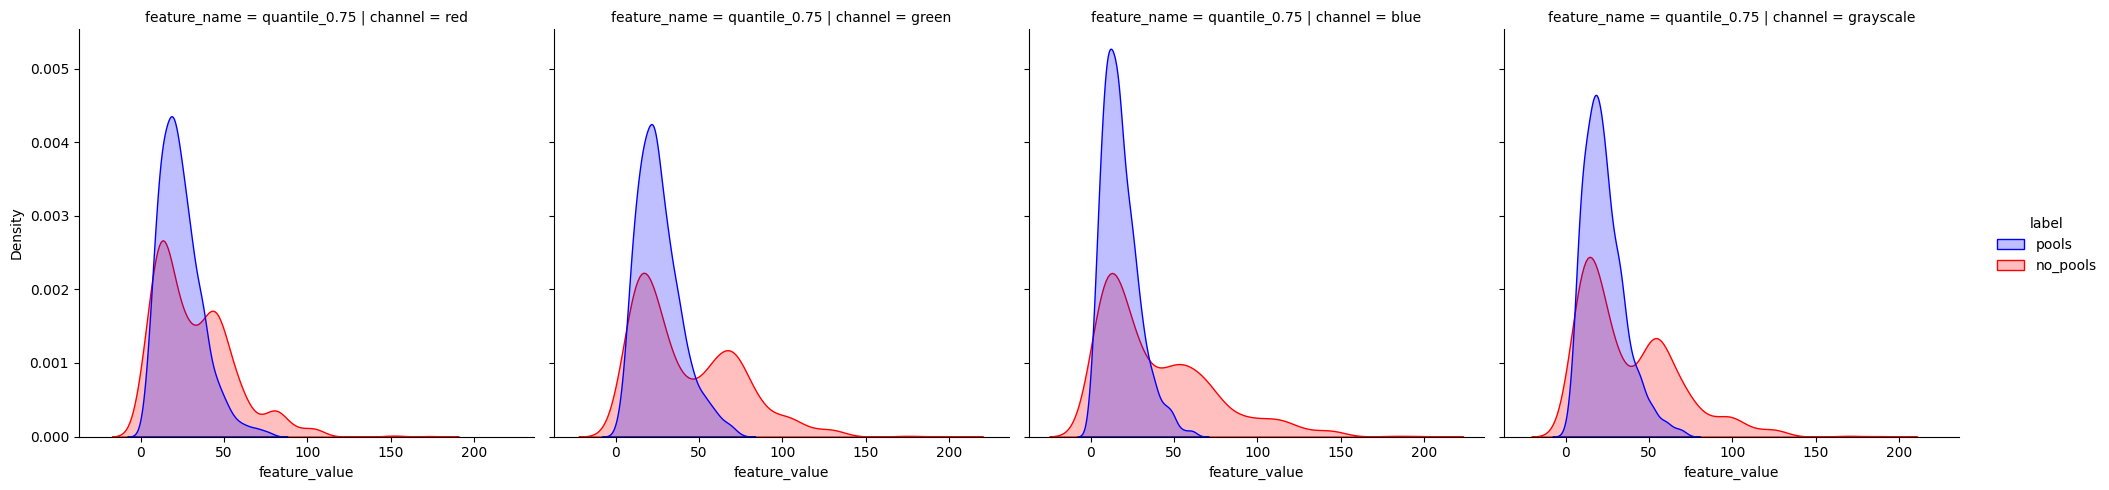

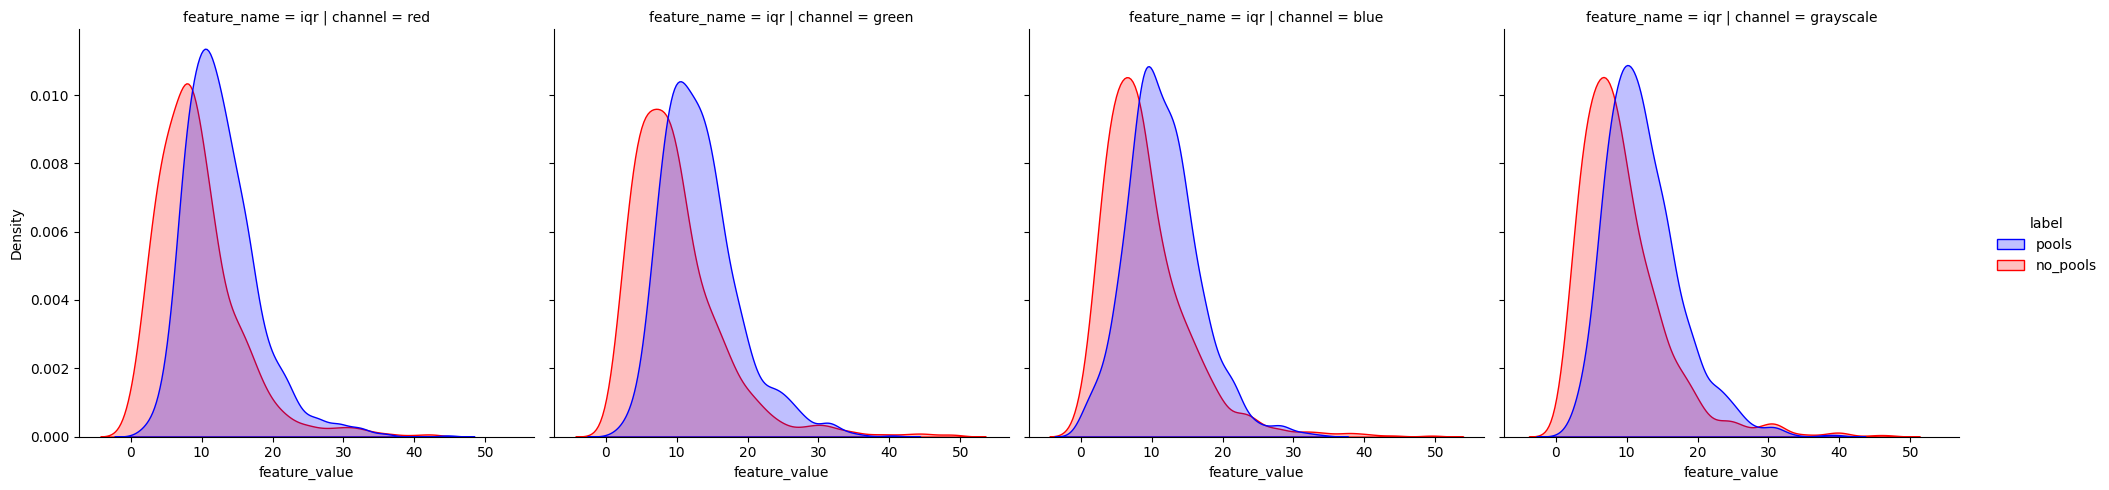

In [385]:
if PLOT_RESULTS:
    for feature_name in model_channel_feature_functions.keys():
        current_feature_df = channel_feature_df[channel_feature_df['feature_name'] == feature_name]
        plot_channel_feature_df(current_feature_df, color='red', secondary_color='blue')

Note that each statistic distribution shows little correlation with label value,
which gives us the insight that it might be difficult to predict using this feature model
(at least from a univariate perspective).

##### **Features de histograma**

In [386]:
def calculate_mean_histogram(histogram: np.ndarray, numBins: int):
    return np.sum((np.arange(numBins) / numBins) * histogram)

def calculate_std_histogram(histogram: np.ndarray, numBins: int):
    mean = calculate_mean_histogram(histogram, numBins)
    return np.sqrt(np.sum(((np.arange(numBins) / numBins) - mean) ** 2 * histogram))

def calculate_median_histogram(histogram: np.ndarray, _: int):
    cumsum = np.cumsum(histogram)
    return np.argmax(cumsum >= cumsum[-1] / 2)

def calculate_mode_histogram(histogram: np.ndarray, _: int):
    return np.argmax(histogram)

def calculate_min_histogram(histogram: np.ndarray, _: int):
    return np.argmin(histogram)

def calculate_max_histogram(histogram: np.ndarray, _: int):
    return np.argmax(histogram)

def calculate_range_histogram(histogram: np.ndarray, _: int):
    return np.argmax(histogram) - np.argmin(histogram)

def calculate_quantile_histogram(histogram: np.ndarray, numBins: int, q: float):
    cum_values = np.cumsum(histogram)
    quantile = np.interp(q * 100, cum_values, np.arange(numBins))
    return quantile

def calculate_iqr_histogram(histogram: np.ndarray, numBins: int):
    return calculate_quantile_histogram(histogram, numBins, q=0.75) - calculate_quantile_histogram(histogram, numBins, q=0.25)

def calculate_skewness_histogram(histogram: np.ndarray, numBins: int):
    mean = calculate_mean_histogram(histogram, numBins)
    skewness = np.sum(((histogram - mean)**3) * histogram)
    return skewness

def calculate_kurtosis_histogram(histogram: np.ndarray, numBins: int):
    mean = calculate_mean_histogram(histogram, numBins)
    kurtosis = np.sum(((histogram - mean)**4) * histogram)
    return kurtosis

def calculate_uniformity_histogram(histogram: np.ndarray, _: int):
    return np.sum(histogram ** 2)

def calculate_entropy_histogram(histogram: np.ndarray, numBins: int):
    entropy = -np.sum(histogram * np.log2(histogram + 1e-12)) / np.log2(numBins)
    return entropy

def calculate_R_histogram(histogram: np.ndarray, _: int):
    R = 1 - 1 / (1 + np.std(histogram)**2)
    return R

In [387]:
model_histogram_feature_functions = {'mean': calculate_mean_histogram,
                                    'std': calculate_std_histogram,
                                    'median': calculate_median_histogram,
                                    'mode': calculate_mode_histogram,
                                    'min': calculate_min_histogram,
                                    'max': calculate_max_histogram,
                                    'range': calculate_range_histogram,
                                    'skewness': calculate_skewness_histogram,
                                    'kurtosis': calculate_kurtosis_histogram,
                                    'uniformity': calculate_uniformity_histogram,
                                    'entropy': calculate_entropy_histogram,
                                    'R': calculate_R_histogram}

In [388]:
def to_grayscale(images: list[tuple]):
    return [np.clip(image.mean(axis=2).astype(int), 0, 255) 
            for image in images]

def to_histogram(image_gray: np.ndarray, bins: int = 256):
    hist, _ = np.histogram(image_gray, bins=bins, density=True)
    return hist

In [389]:
def create_histogram_features_df(images: list[tuple], 
                                 labels: list,
                                 ids: list,
                                 model_histogram_feature_functions: dict, 
                                 bins=256):
    pixels_df = collections.defaultdict(list)
    grayscale_images = to_grayscale(images)

    for image, label, id in zip(grayscale_images, labels, ids):
        image_histogram = to_histogram(image, bins=bins)

        for feature_name, feature_function in model_histogram_feature_functions.items():
            pixels_df['image_id'].append(id)
            pixels_df['feature_value'].append(feature_function(image_histogram, bins))
            pixels_df['feature_name'].append(feature_name)
            pixels_df['label'].append(label)

    df = pd.DataFrame(pixels_df)
    df['feature_value'] = df['feature_value'].astype(float)
    return df

In [390]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'histogram_feature_df.csv')):
    histogram_feature_df = pd.read_csv(os.path.join(FEATURES_DIR, 'histogram_feature_df.csv'))
else:
    histogram_feature_df = create_histogram_features_df(train_images, 
                                                        train_labels, 
                                                        train_ids,
                                                        model_histogram_feature_functions)
    histogram_feature_df.to_csv(os.path.join(FEATURES_DIR,  'histogram_feature_df.csv'), 
                                index=False)

In [391]:
def plot_features_violinplot(feature_df: pd.DataFrame):
    _, ax = plt.subplots(nrows=1, figsize=(20, 5))
    feature_df = scale_feature_df(feature_df)
    sns.violinplot(data=feature_df, x='feature_name', y='feature_value', hue='label', ax=ax)
    ax.legend(fontsize=10)
    plt.tight_layout()

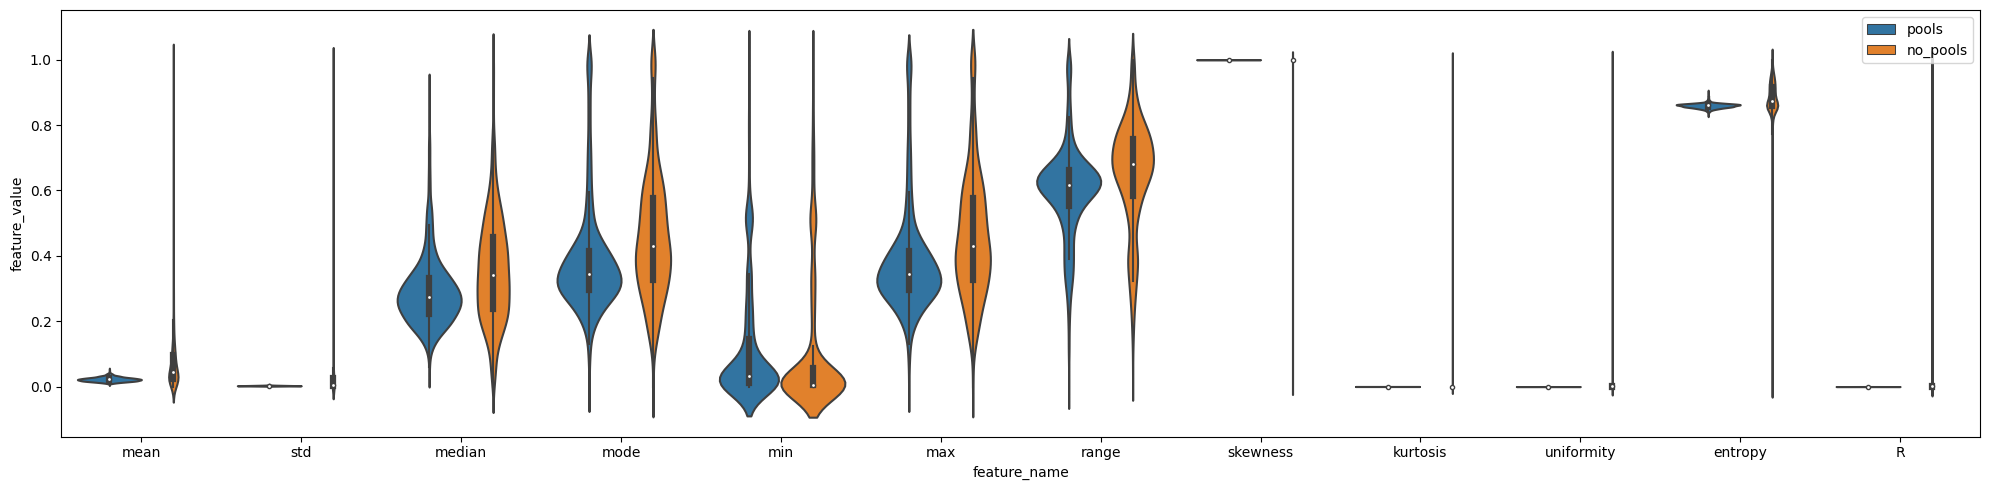

In [392]:
if PLOT_RESULTS:
    plot_features_violinplot(histogram_feature_df)

In [393]:
def plot_feature_df(pixels_df, color='red', secondary_color='blue', width=None, height=None):
    facet_grid = sns.displot(pixels_df, 
                             x='feature_value', 
                             hue='label', 
                             fill=True, 
                             palette=[secondary_color, color], 
                             kind='kde', 
                             col='feature_name')
    facet_grid.fig.set_figwidth(width) if width else None
    facet_grid.fig.set_figheight(height) if height else None

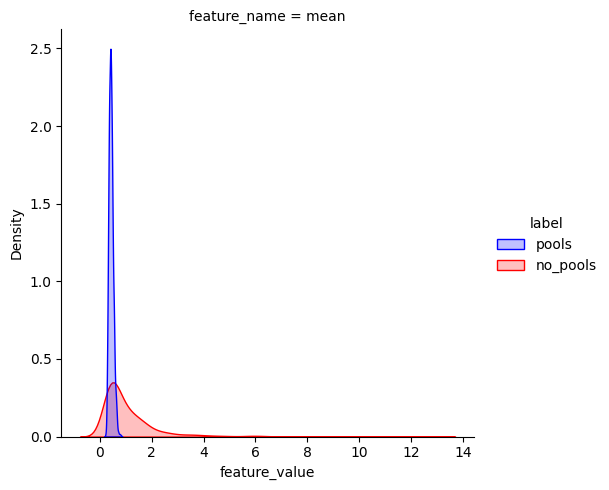

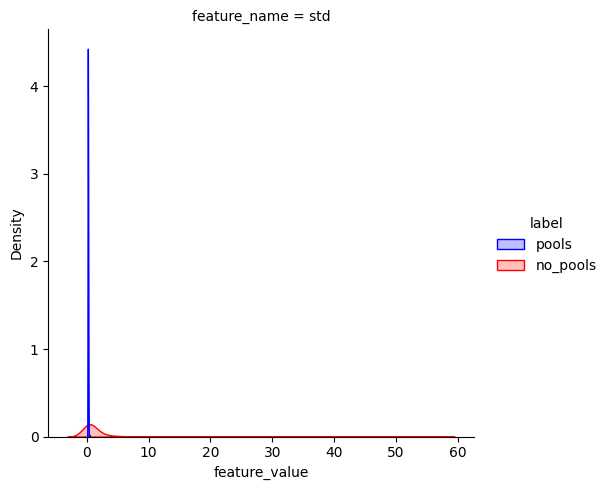

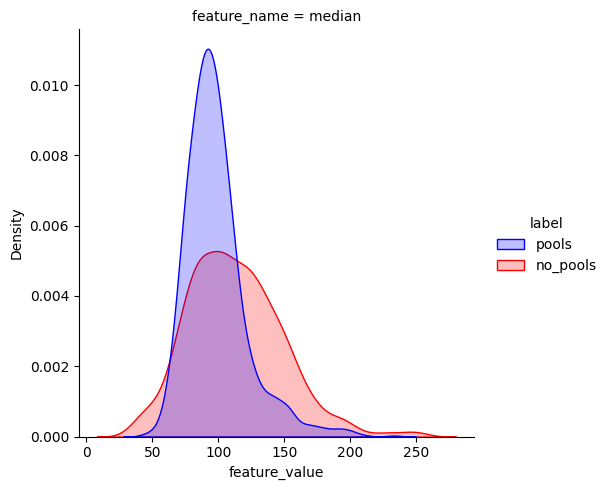

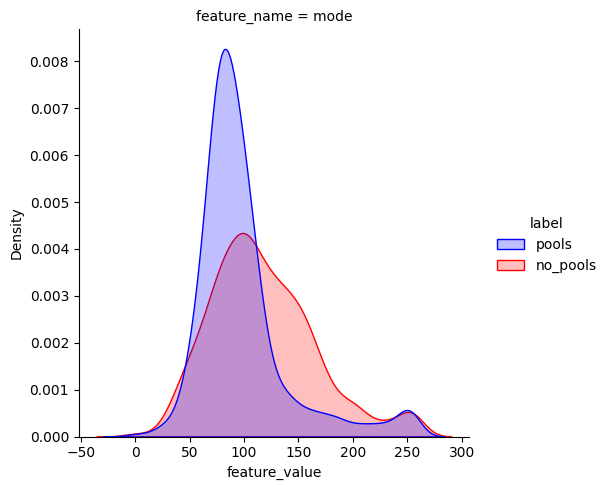

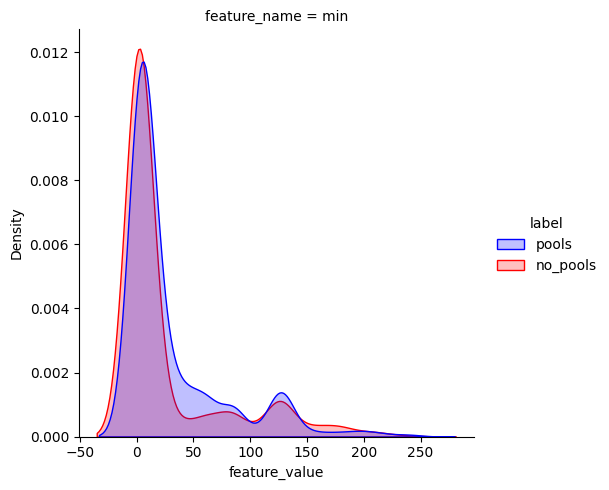

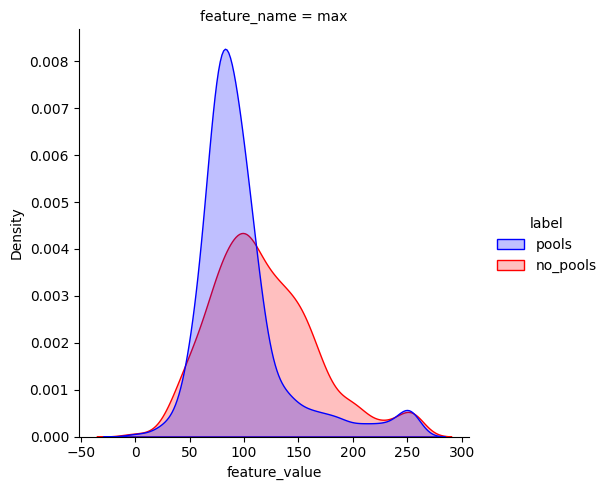

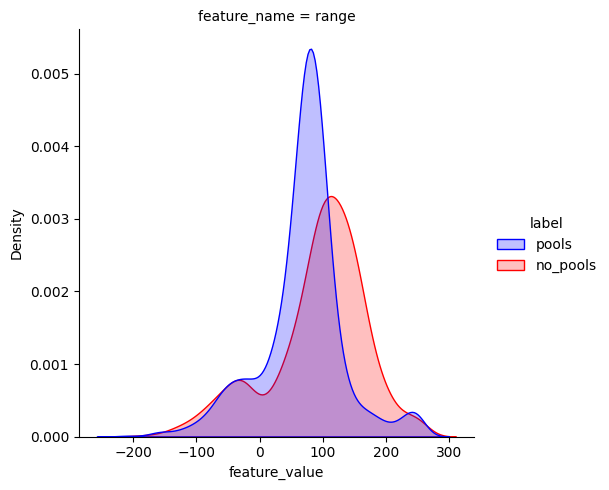

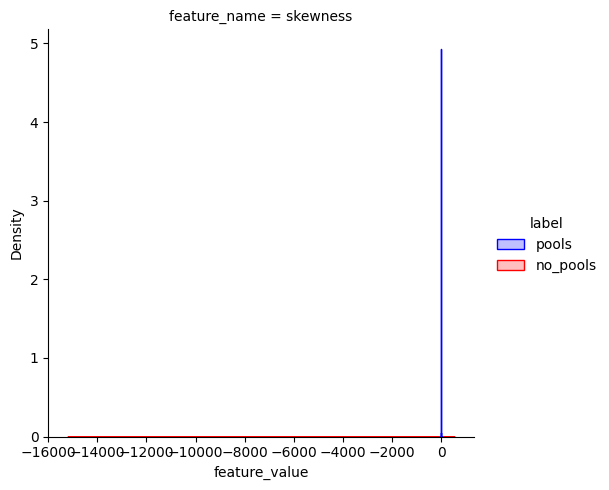

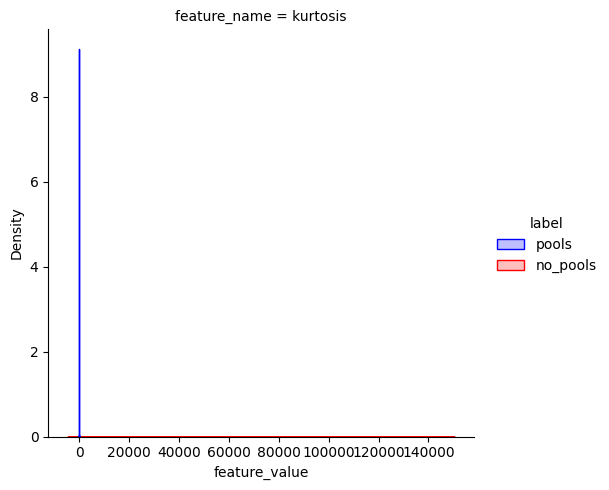

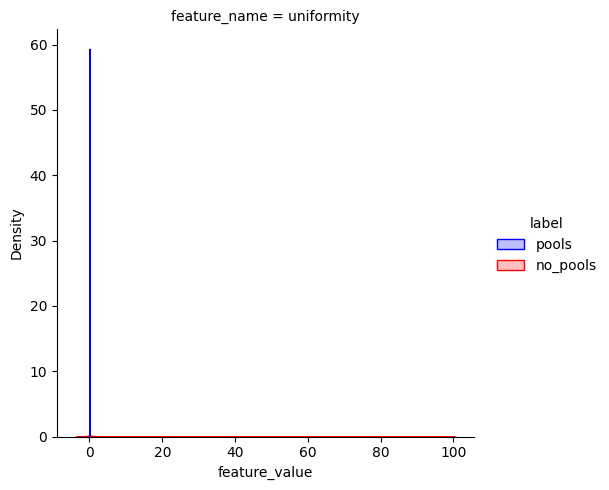

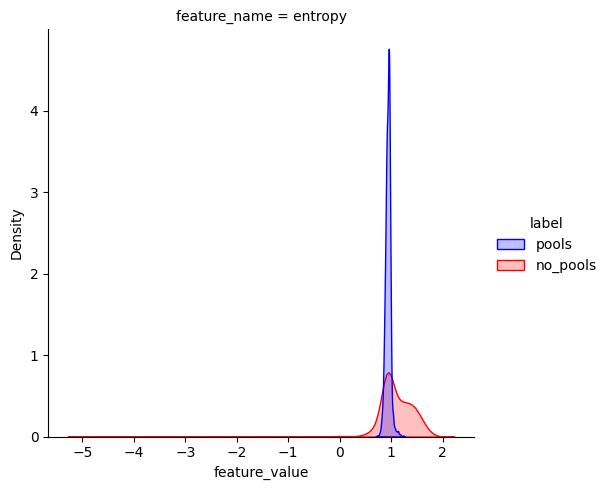

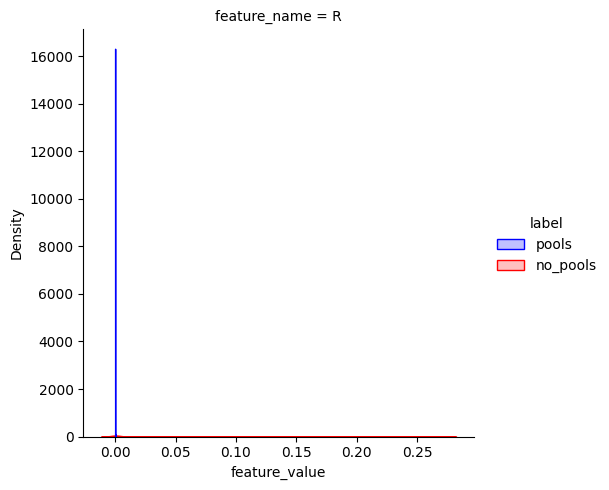

In [394]:
if PLOT_RESULTS:
    for feature_name in model_histogram_feature_functions.keys():
        current_feature_df = histogram_feature_df[histogram_feature_df['feature_name'] == feature_name]
        plot_feature_df(current_feature_df, 
                        color='red', 
                        secondary_color='blue')

##### **Statistics of the Correlation Matrix**

In [395]:
def create_coocurrence_matrix_df(images: list, 
                                 labels: list,
                                 ids: list,
                                 distance, angle, 
                                 levels=256):
    pixels_df = collections.defaultdict(list)
    grayscale_images = to_grayscale(images)

    for image, label, id in zip(grayscale_images, labels, ids):
        co_occurrence_matrix = graycomatrix(image, 
                                            [distance],
                                            [angle],
                                            levels=levels, 
                                            normed=True,
                                            symmetric=True)

        for feature in ['contrast', 'dissimilarity', 
                        'homogeneity', 'energy', 'correlation']:
            pixels_df['image_id'].append(id)
            pixels_df['feature_value'].append(graycoprops(co_occurrence_matrix, 
                                                          feature)[0, 0])
            pixels_df['feature_name'].append(feature)
            pixels_df['label'].append(label)

    df = pd.DataFrame(pixels_df)
    df['feature_value'] = df['feature_value'].astype(float)
    return df

In [396]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'coocurrence_matrix_df.csv')):
    coocurrence_matrix_df = pd.read_csv(os.path.join(FEATURES_DIR, 'coocurrence_matrix_df.csv'))
else:
    coocurrence_matrix_df = create_coocurrence_matrix_df(train_images,
                                                         train_labels,
                                                         train_ids,
                                                         distance=1, 
                                                         angle=0)
    coocurrence_matrix_df.to_csv(os.path.join(FEATURES_DIR, 'coocurrence_matrix_df.csv'), 
                                 index=False)

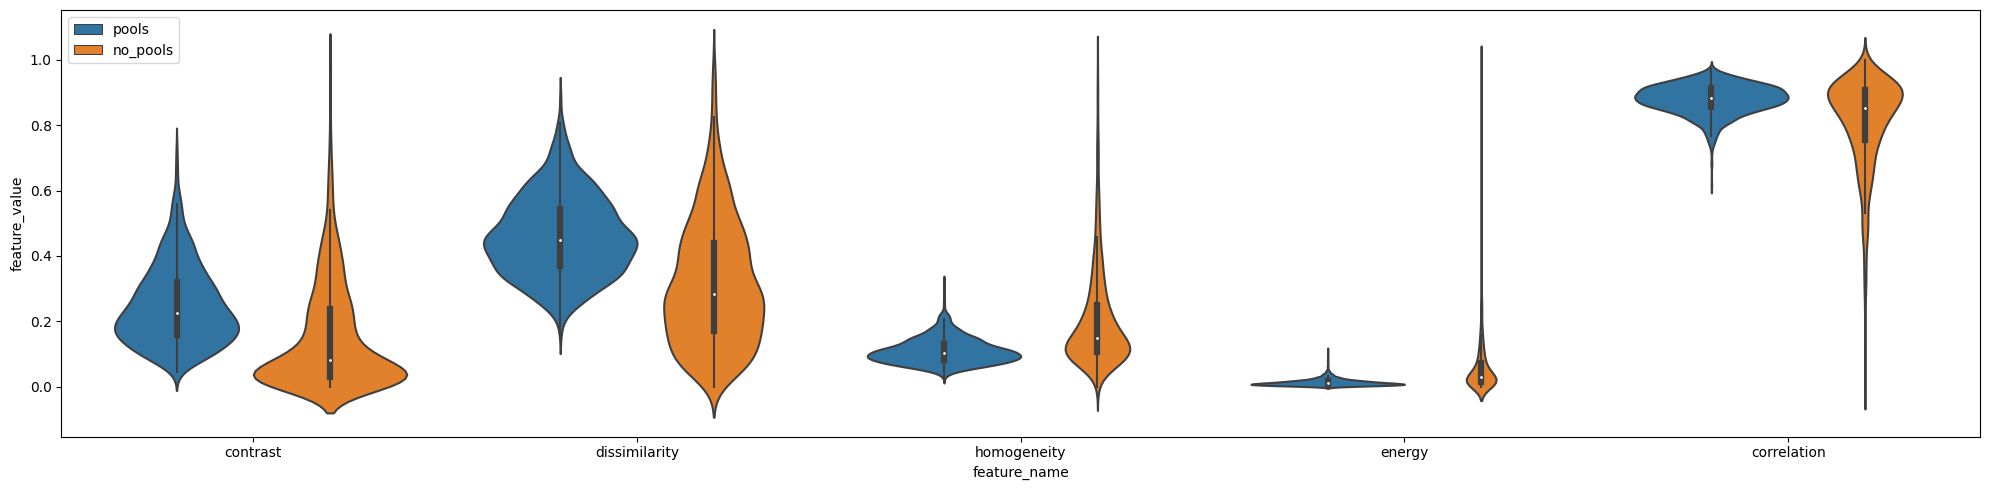

In [397]:
if PLOT_RESULTS:
    plot_features_violinplot(coocurrence_matrix_df)

In [398]:
coocurrence_matrix_df.head()

image_id  feature_value  \
0  ..\data\datasets\yacine\original_splits\train\...     202.863673   
1  ..\data\datasets\yacine\original_splits\train\...       8.520000   
2  ..\data\datasets\yacine\original_splits\train\...       0.149069   
3  ..\data\datasets\yacine\original_splits\train\...       0.029522   
4  ..\data\datasets\yacine\original_splits\train\...       0.854207   

    feature_name  label  
0       contrast  pools  
1  dissimilarity  pools  
2    homogeneity  pools  
3         energy  pools  
4    correlation  pools

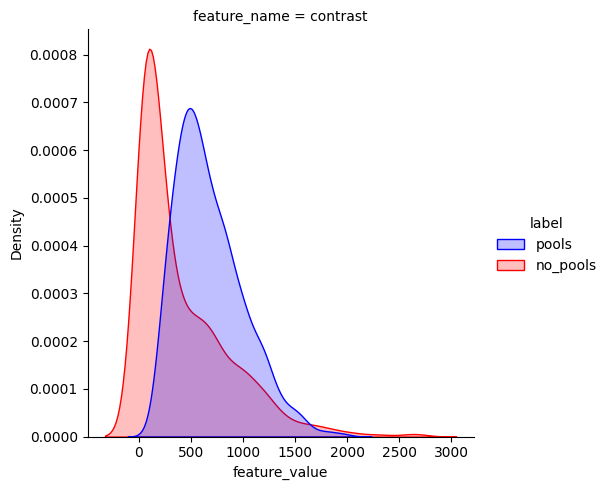

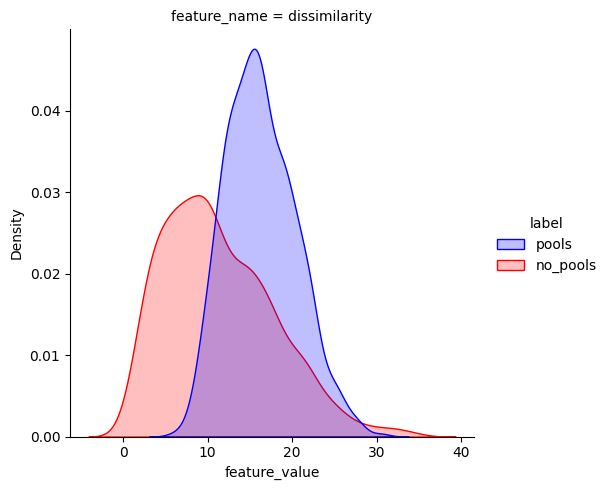

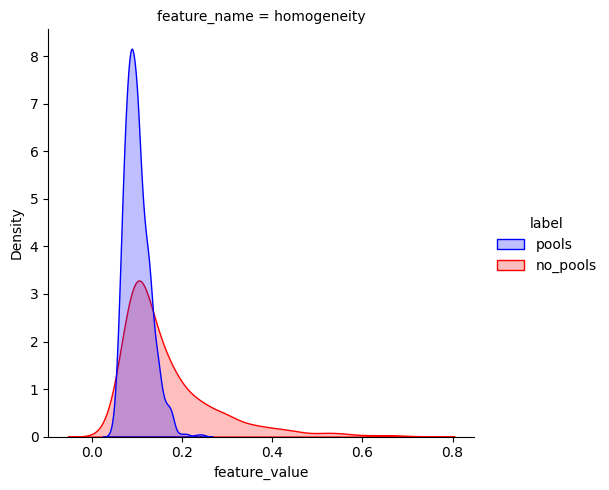

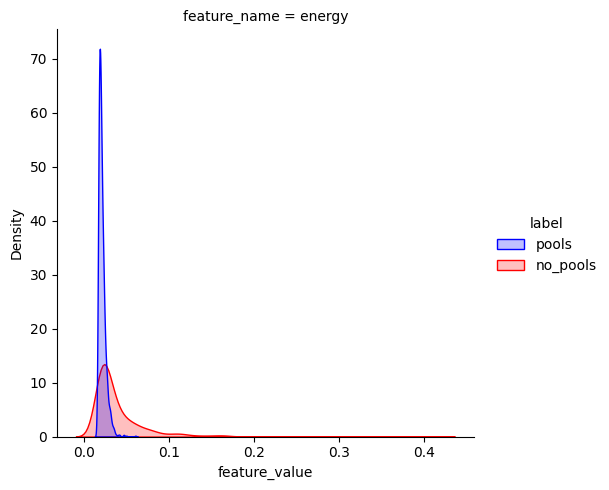

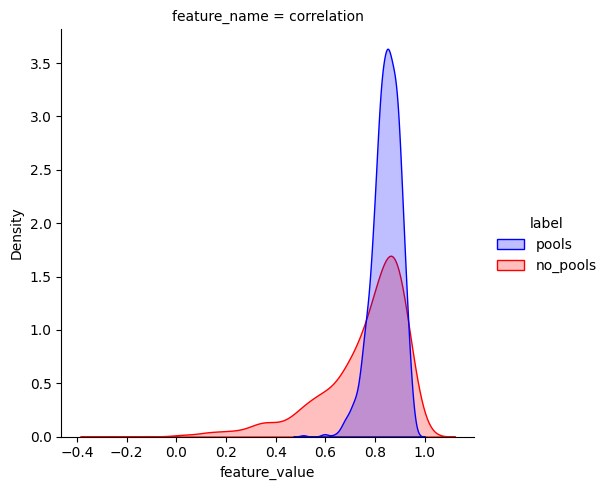

In [399]:
if PLOT_RESULTS:
    for feature_name in coocurrence_matrix_df['feature_name'].unique():
        current_feature_df = coocurrence_matrix_df[coocurrence_matrix_df['feature_name'] == feature_name]
        plot_feature_df(current_feature_df, 
                        color='red', 
                        secondary_color='blue')

### **Feature datasets merge**

In [400]:
def rename_feature(feature_name: str, suffix: str):
    return feature_name + '_' + suffix
    
def merge_features(color_features: pd.DataFrame, 
                    channel_features: pd.DataFrame, 
                    histogram_features: pd.DataFrame, 
                    coocurrence_matrix_features: pd.DataFrame):
    color_feature_columns = [rename_feature(row['feature_name'], 'color') 
                             for _, row in color_features.iterrows()]
    channel_feature_columns = [rename_feature(row['feature_name'], row['channel']) 
                               for _, row in channel_features.iterrows()]
    histogram_feature_columns = [rename_feature(row['feature_name'], 'histogram') 
                                 for _, row in histogram_features.iterrows()]
    
    coocurrence_matrix_feature_columns = [rename_feature(row['feature_name'], 
                                                         'coocurrence_matrix') 
                                          for _, row in coocurrence_matrix_features.iterrows()]
    
    feature_columns = [*channel_feature_columns, 
                       *histogram_feature_columns, 
                       *coocurrence_matrix_feature_columns, 
                       *color_feature_columns]

    image_initial_features = {**{feature_name: None for feature_name in feature_columns}, 
                                 'label': None}
    image_features = {image_id: image_initial_features.copy() 
                      for image_id in channel_features['image_id'].unique()}
    ingested_df = {'image_id': [], 
                   **{feature_name: [] for feature_name in feature_columns}, 
                      'label': []}
    visited_images = set()

    # Individual datasets
    for _, row in color_features.iterrows():
        image_id = row['image_id']
        renamed_feature = rename_feature(row['feature_name'], 'color')
        feature_value = row['feature_value']
        image_features[image_id][renamed_feature] = feature_value
        if image_id not in visited_images:
            image_features[image_id]['label'] = row['label']
            visited_images.add(image_id)

    for _, row in channel_features.iterrows():
        image_id = row['image_id']
        renamed_feature = rename_feature(row['feature_name'], row['channel'])
        feature_value = row['feature_value']
        image_features[image_id][renamed_feature] = feature_value

    for _, row in histogram_features.iterrows():
        image_id = row['image_id']
        renamed_feature = rename_feature(row['feature_name'], 'histogram')
        feature_value = row['feature_value']
        image_features[image_id][renamed_feature] = feature_value

    for _, row in coocurrence_matrix_features.iterrows():
        image_id = row['image_id']
        renamed_feature = rename_feature(row['feature_name'], 'coocurrence_matrix')
        feature_value = row['feature_value']
        image_features[image_id][renamed_feature] = feature_value

    # Mixed dataset
    for image_id, features in image_features.items():
        for feature_name, feature_values in features.items():
            ingested_df[feature_name].append(feature_values) if feature_name != 'label' else None
        ingested_df['image_id'].append(image_id)
        ingested_df['label'].append(features['label'])


    return pd.DataFrame(ingested_df)

In [401]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'ingested_features_df.csv')):
    ingested_features_df = pd.read_csv(os.path.join(FEATURES_DIR, 'ingested_features_df.csv'))
else:
    ingested_features_df = merge_features(color_features_df, 
                                          channel_feature_df, 
                                          histogram_feature_df, 
                                          coocurrence_matrix_df)
    ingested_features_df.to_csv(os.path.join(FEATURES_DIR, 'ingested_features_df.csv'), index=False)

#### **Normality Test**

In [402]:
from scipy.stats import shapiro, kstest

def shapiro_wilk_test(features: pd.Series):
    _, pvalue = shapiro(features)
    return pvalue

def kolmogorov_smirnov_test(features: pd.Series):
    _, pvalue = kstest(features, 'norm', args=(features.mean(), features.std(ddof=1))) #ddof = 1 para usar desviación estándar muestral
    return pvalue

# The Shapiro–Wilk test is more appropriate method for small sample sizes 
# (<50 samples) although it can also be handling on larger sample size while Kolmogorov–Smirnov test is used for n ≥50.
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6350423/
def create_normality_df(features_df: pd.DataFrame, test='kolmogorov_smirnov'):
    test_functions = {'shapiro_wilk': shapiro_wilk_test, 'kolmogorov_smirnov': kolmogorov_smirnov_test}
    normality_df = {'feature_name': [], 'pvalue': [], 'is_normal': []}
    categorical_features = features_df.select_dtypes(include='object').columns
    for feature_name in features_df.columns:
        if feature_name not in categorical_features:
            pvalue = test_functions[test](features_df[feature_name])
            normality_df['feature_name'].append(feature_name)
            normality_df['pvalue'].append(pvalue)
            normality_df['is_normal'].append(pvalue > 0.05)
    return pd.DataFrame(normality_df)

In [403]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'normality_df.csv')):
    normality_df = pd.read_csv(os.path.join(FEATURES_DIR, 'normality_df.csv'))
else:
    normality_df = create_normality_df(ingested_features_df)
    normality_df.to_csv(os.path.join(FEATURES_DIR, 'normality_df.csv'), index=False)

In [404]:
def plot_normality_df(normality_df: pd.DataFrame, scale='log'):
    _, ax = plt.subplots(figsize=(20, 5))
    sns.barplot(data=normality_df, x='feature_name', y='pvalue', hue='is_normal', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.plot([0, len(normality_df)-1], [0.05, 0.05], linewidth=2, color='red')
    plt.yscale(scale)
    plt.tight_layout()

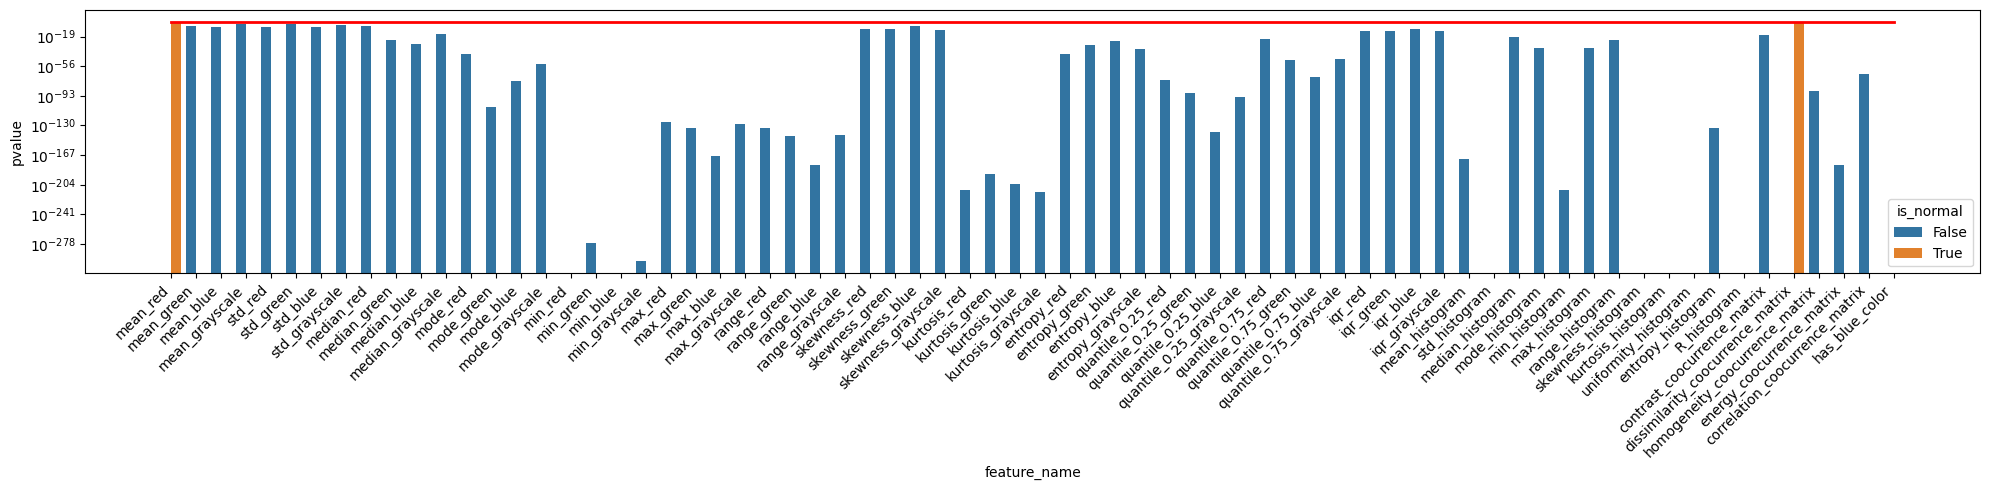

In [405]:
if True:
    plot_normality_df(normality_df)

Here, according to the performed statistical test, the null hypothesis that each individual statistic
follows a normal distribution is rejected for all but 2 features. Because of this, from now on
we will use non-parametric methods.

### **Significance**

In this section we will analyse the importance of each feature according to the Mutual Information non-parametric method, 
which measures the distance between two distributions. In this case those two are the feature and the target column.

#### **Mutual Information**

In [406]:
def create_mutual_info_df(X, y, descriptors):
    mutual_info_statistics = mutual_info_classif(X, y, random_state=0)
    mutual_info_df = pd.DataFrame({'importance': mutual_info_statistics}, index=descriptors)
    mutual_info_df.sort_values(by='importance', ascending=False, inplace=True)
    return mutual_info_df

In [407]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'mutual_info_df.csv')):
    mutual_info_df = pd.read_csv(os.path.join(FEATURES_DIR, 'mutual_info_df.csv'), index_col='feature_name')
else:
    numeric_features = ingested_features_df.select_dtypes(include='number').columns
    X = ingested_features_df[numeric_features]
    y = ingested_features_df['label']
    mutual_info_df = create_mutual_info_df(X, y, numeric_features)
    mutual_info_df.to_csv(os.path.join(FEATURES_DIR, 'mutual_info_df.csv'), index=True, index_label='feature_name')

In [408]:
def plot_mutual_info_df(importances_df: pd.DataFrame):
    _, ax = plt.subplots(figsize=(20, 5))
    sns.barplot(data=importances_df, x=importances_df.index, y='importance', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout()

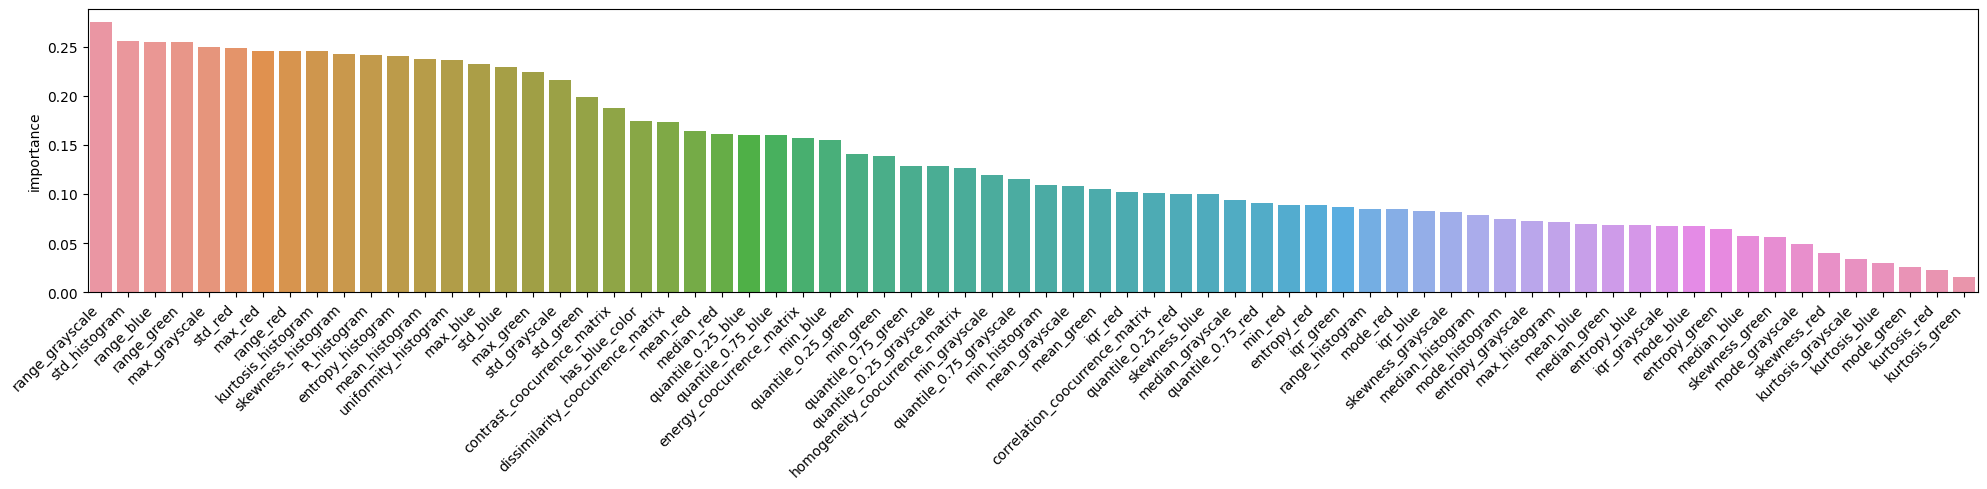

In [409]:
if PLOT_RESULTS:
    plot_mutual_info_df(mutual_info_df)

## **Correlation Coefficient**

Here we will use spearman correlation function to determine which group of features are
highly (perfectly) correlated. If they are, we will drop the one with the highest mutual information
(we could also drop random features).

In [410]:
def plot_feature_correlation(feature_df: pd.DataFrame, 
                             threshold: float=None, 
                             normal=False, 
                             plot=True):
    if plot:
        _, ax = plt.subplots(figsize=(15, 15))
    method = 'pearson' if normal else 'spearman' #https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
    corr = feature_df.corr(numeric_only=True, method=method).abs()
    if threshold:
        corr[corr < threshold] = 0
        corr[corr >= threshold] = 1
    if plot:
        sns.heatmap(corr, annot=False, ax=ax)
    return corr

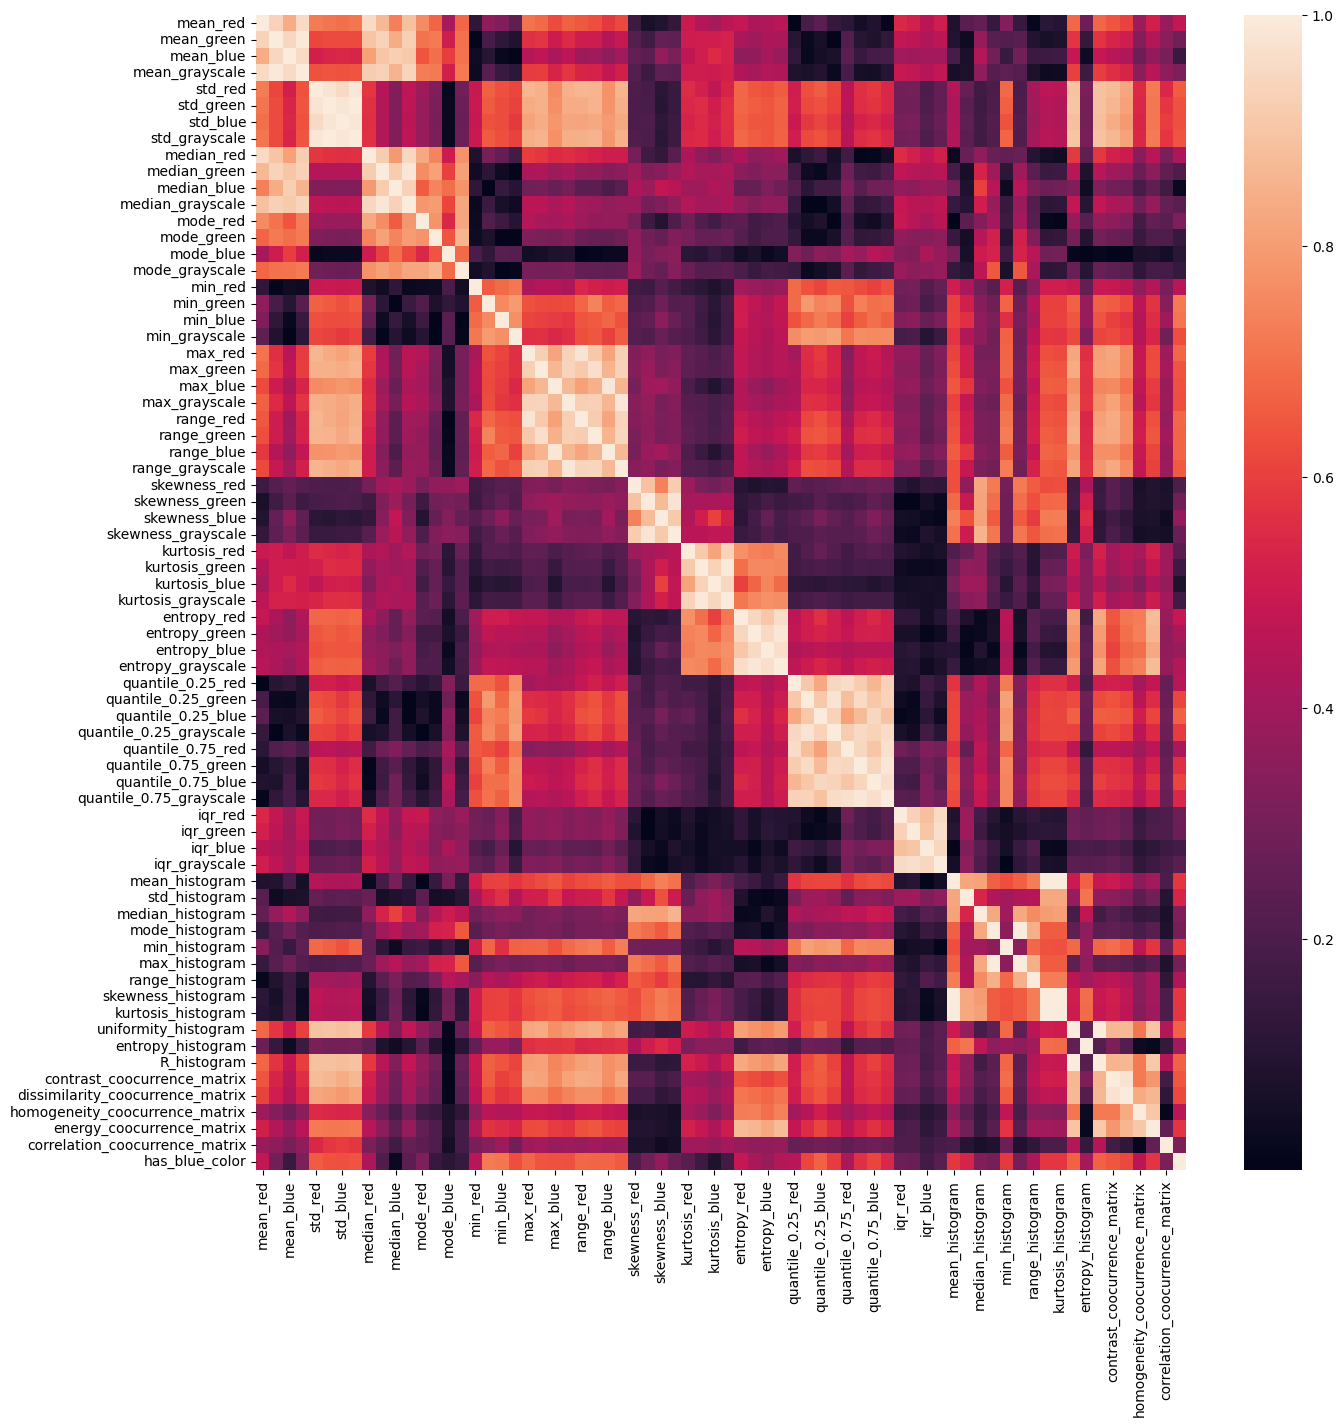

In [411]:
correlated_features = plot_feature_correlation(ingested_features_df, plot=PLOT_RESULTS)

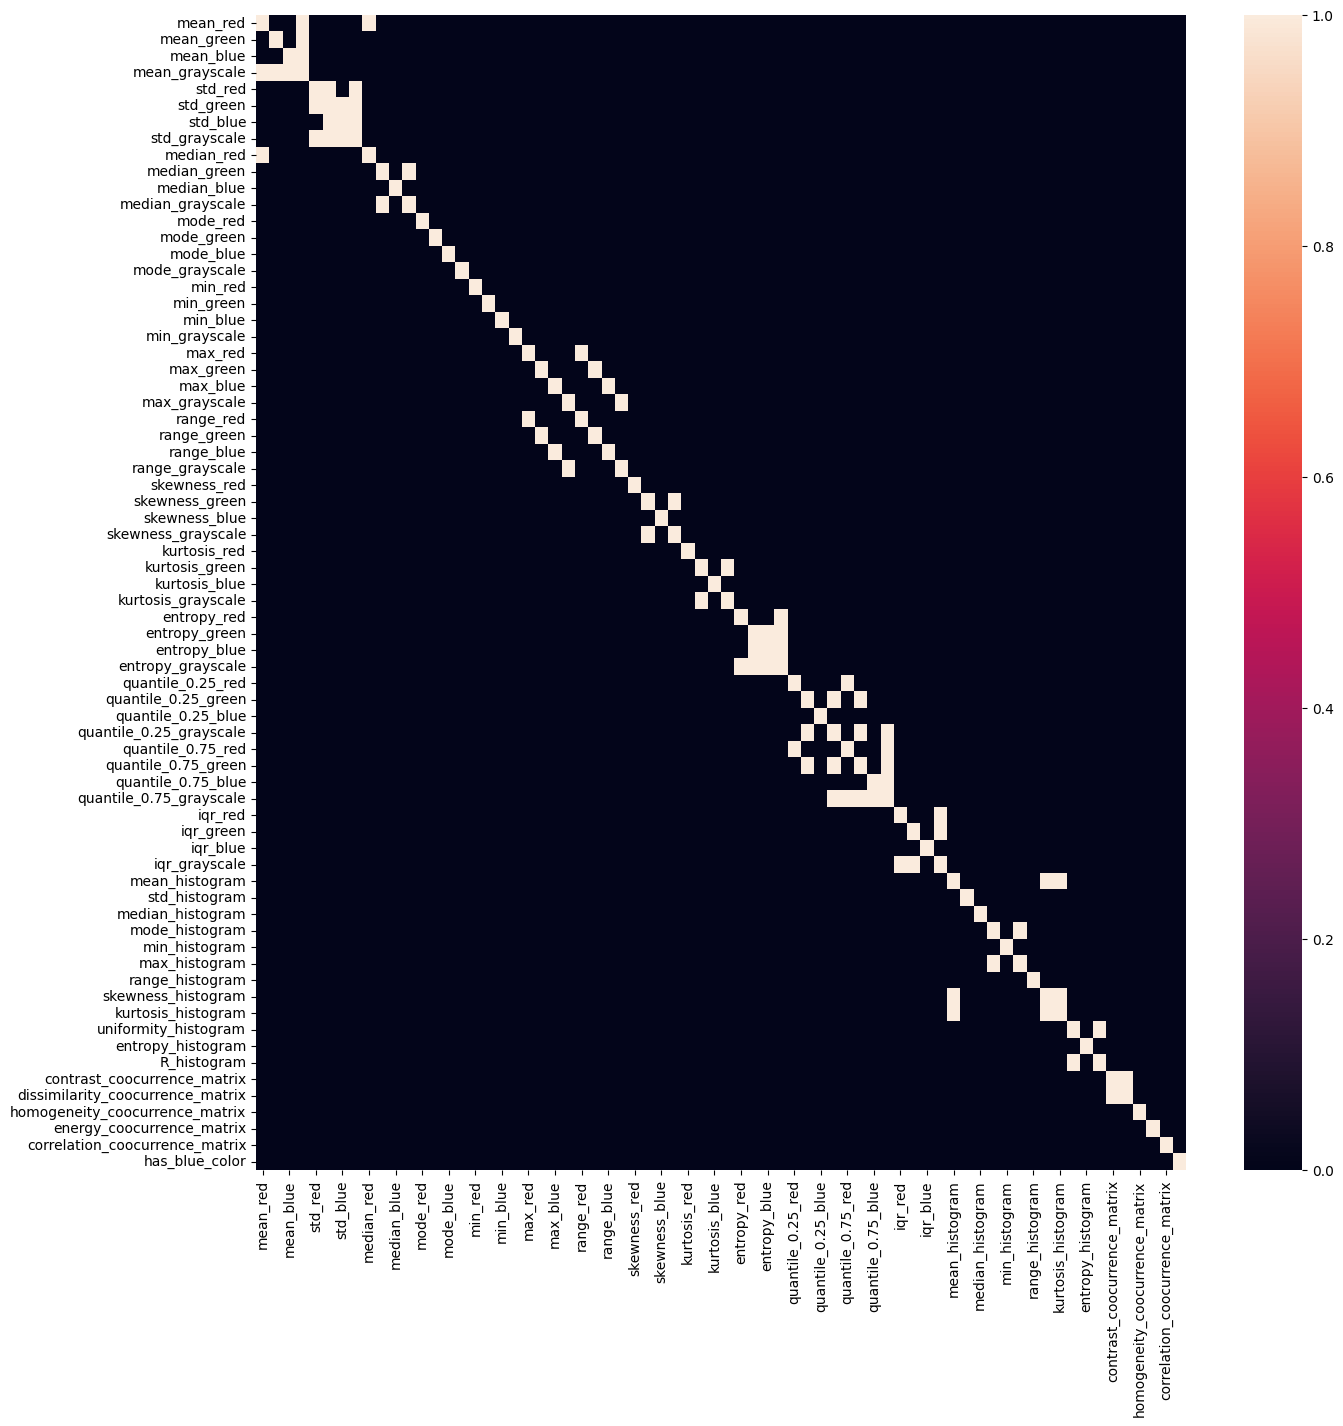

In [412]:
if PLOT_RESULTS:
    plot_feature_correlation(ingested_features_df, threshold=0.95, plot=True)

**Highly correlated features**

In [413]:
CORR_THRESHOLD = 0.95

def get_correlated_features(correlated_features: pd.DataFrame, mutual_info_df: pd.DataFrame, threshold: float=CORR_THRESHOLD, debug=True):
    correlated_features_to_drop = set()
    for name_1 in correlated_features.columns:
        for name_2 in correlated_features.columns:
            if name_1 != name_2:
                if correlated_features[name_1][name_2] > threshold:
                    if (name_1 not in correlated_features_to_drop) and (name_2 not in correlated_features_to_drop):
                        if debug:
                            print(f'Features: {name_1} - {name_2} \n Correlation: {correlated_features[name_1][name_2]:.4f} \n Importance: {mutual_info_df["importance"][name_1]:.4f} - {mutual_info_df["importance"][name_2]:.4f}\n ')
                        if mutual_info_df['importance'][name_1] > mutual_info_df['importance'][name_2]:
                            correlated_features_to_drop.add(name_2)
                        else:
                            correlated_features_to_drop.add(name_1)
    return list(correlated_features_to_drop)

In [414]:
get_correlated_features(correlated_features, mutual_info_df);

Features: mean_red - mean_grayscale 
 Correlation: 0.9561 
 Importance: 0.1642 - 0.1078
 
Features: mean_red - median_red 
 Correlation: 0.9535 
 Importance: 0.1642 - 0.1607
 
Features: std_red - std_green 
 Correlation: 0.9788 
 Importance: 0.2481 - 0.1982
 
Features: std_red - std_grayscale 
 Correlation: 0.9862 
 Importance: 0.2481 - 0.2161
 
Features: median_green - median_grayscale 
 Correlation: 0.9861 
 Importance: 0.0688 - 0.0936
 
Features: max_red - range_red 
 Correlation: 0.9783 
 Importance: 0.2451 - 0.2450
 
Features: max_green - range_green 
 Correlation: 0.9676 
 Importance: 0.2241 - 0.2543
 
Features: max_blue - range_blue 
 Correlation: 0.9853 
 Importance: 0.2325 - 0.2544
 
Features: max_grayscale - range_grayscale 
 Correlation: 0.9855 
 Importance: 0.2494 - 0.2745
 
Features: skewness_green - skewness_grayscale 
 Correlation: 0.9787 
 Importance: 0.0561 - 0.0815
 
Features: kurtosis_green - kurtosis_grayscale 
 Correlation: 0.9885 
 Importance: 0.0156 - 0.0337
 
Fe

In [415]:
with open(os.path.join(FEATURES_DIR, 'correlated_features.txt'), 'w') as f:
    correlated_features_to_drop = get_correlated_features(correlated_features, mutual_info_df, debug=False)
    f.write('\n'.join(correlated_features_to_drop))

#### **Multivariate analysis**

Here, we will simply use a pairplot to show how much taking more than one feature into consideration
enhances our results.

We will simply use 10 features as pairplot is expensive to compute, and we have more than 70 features.

In [416]:
def pairplot_features(feature_df: pd.DataFrame, label: str):
    sns.pairplot(feature_df, hue=label)

**Pairplot**

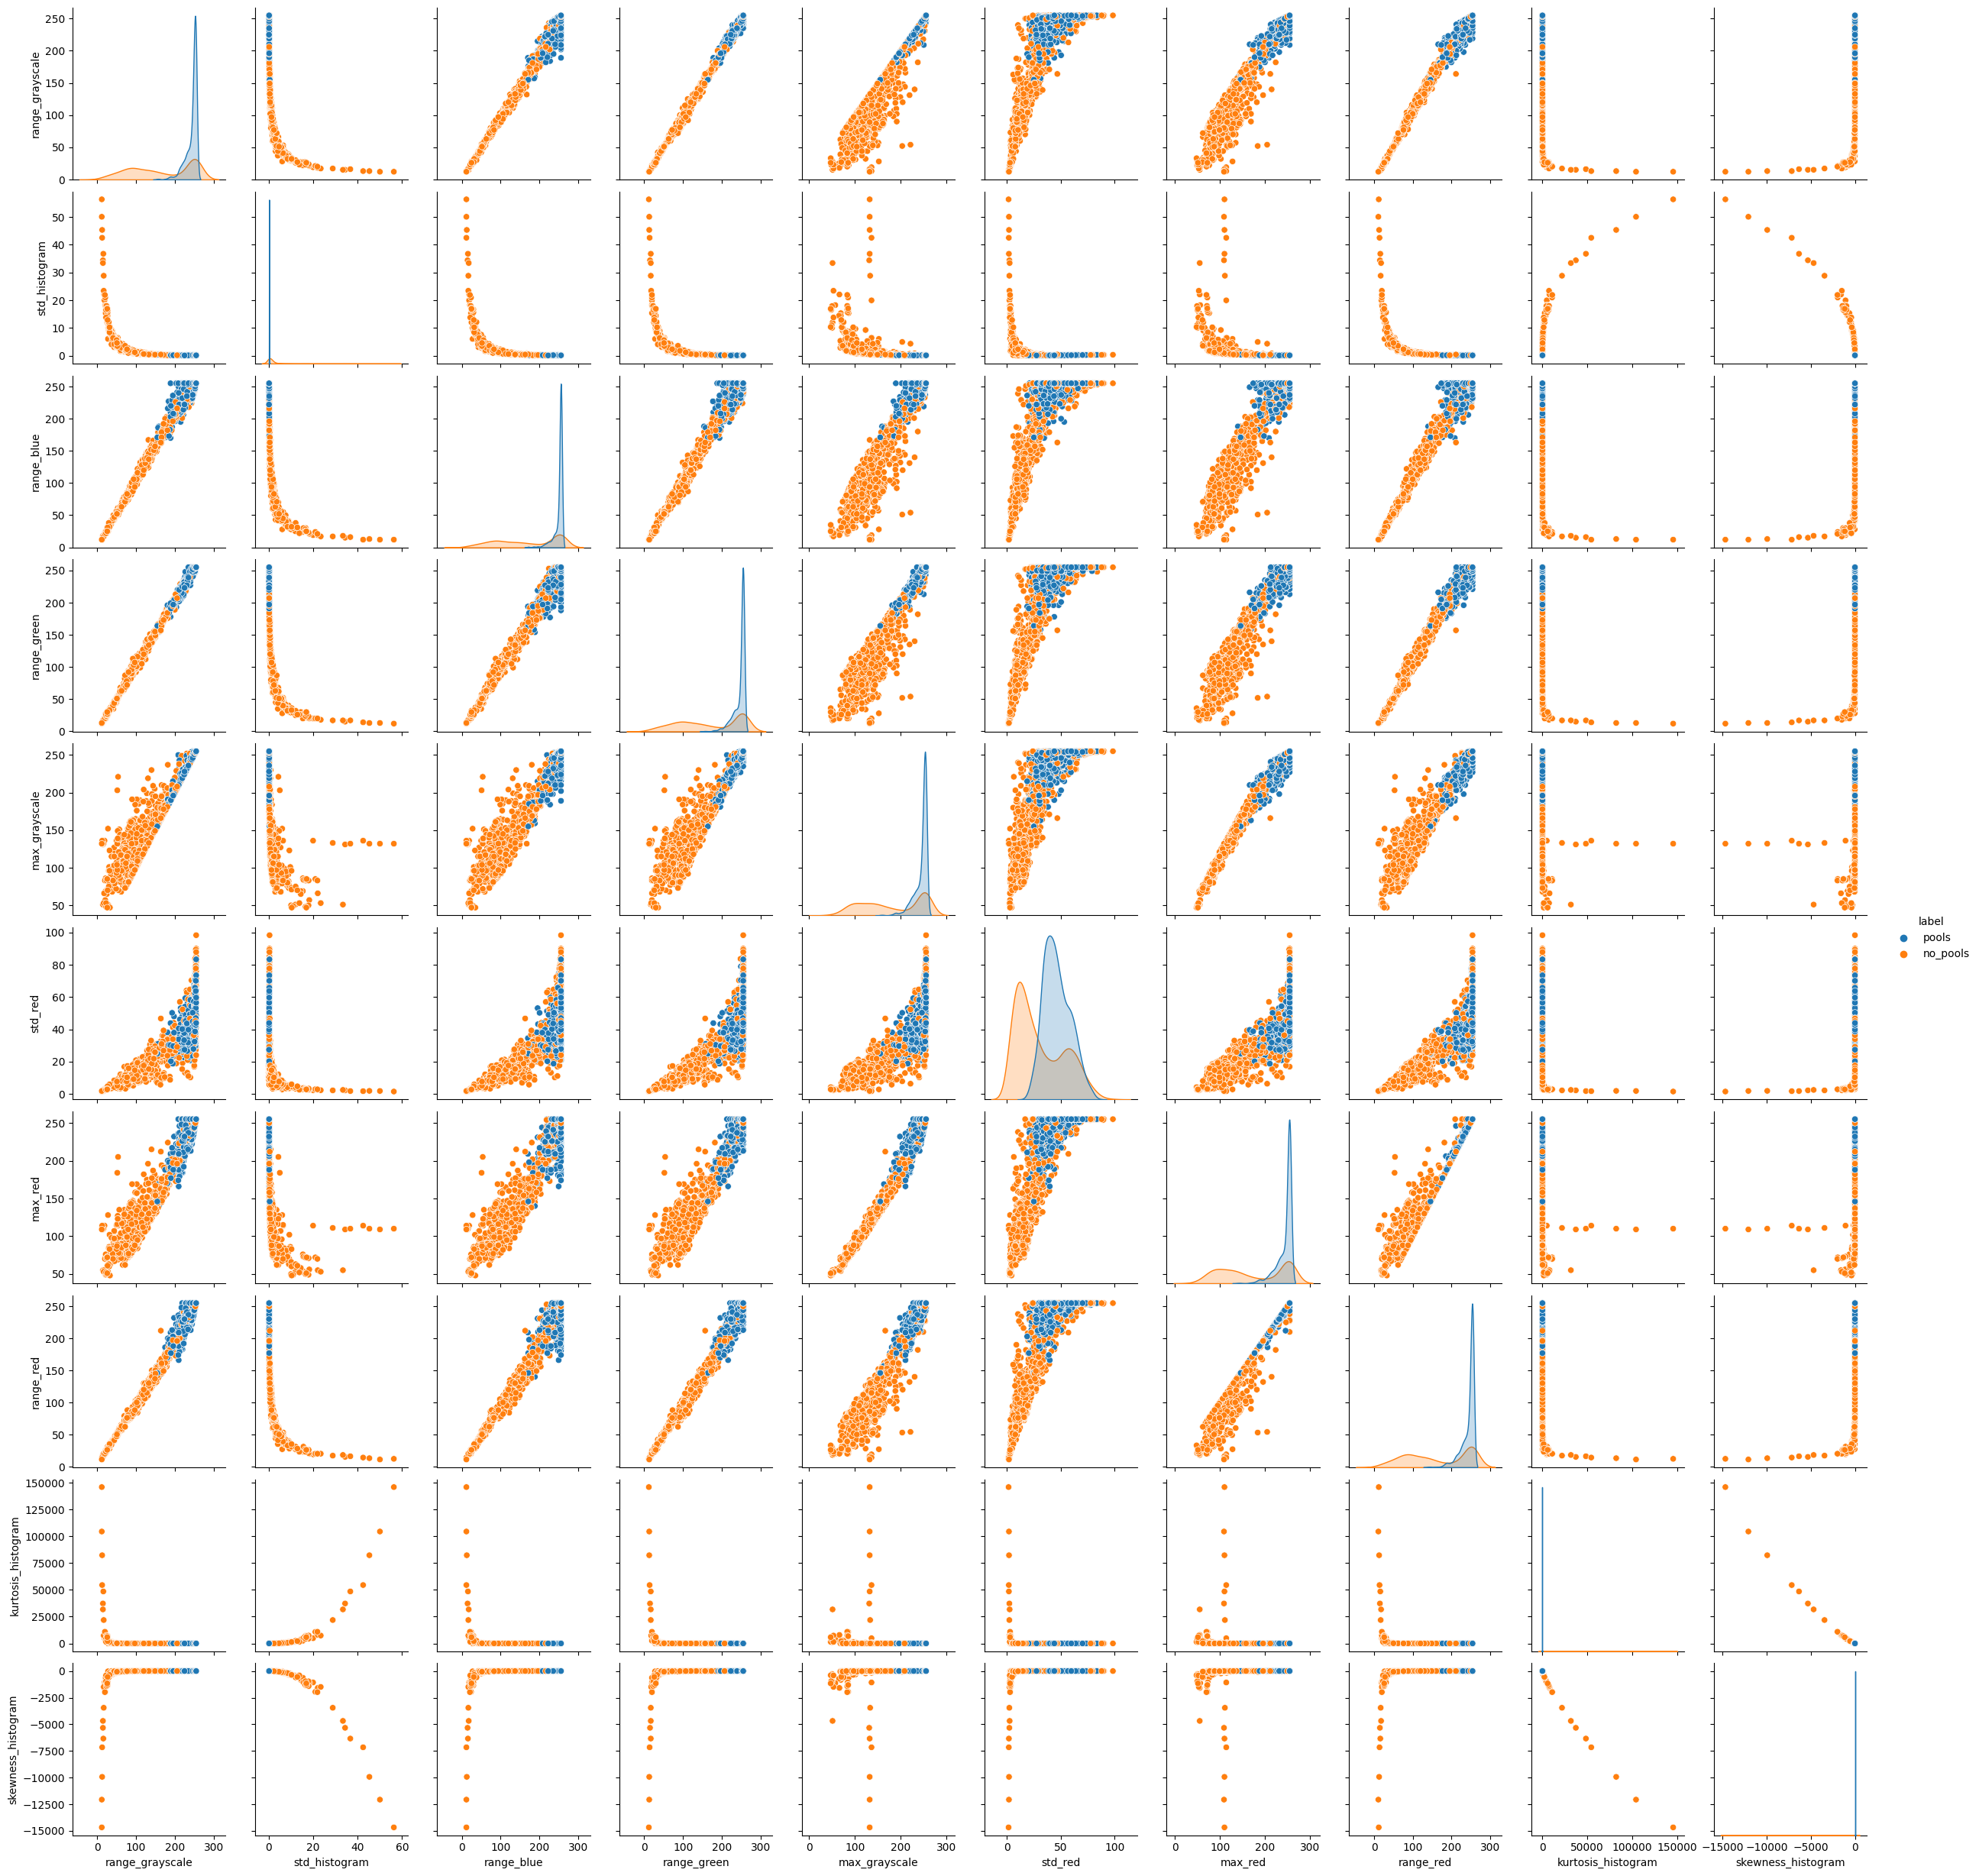

In [417]:
if PLOT_RESULTS:
    top_feature_columns = list(mutual_info_df.index[0:10]) + ['label']
    pairplot_features(ingested_features_df[top_feature_columns], label='label')

Although this results are not perfect, these are substantially more optimistic than
the univariate plots, as here the two classes are clustered undeniably better.